# 0 Double Machine Learning Main Analysis

This notebook implements the Double Machine Learning (DML) methodology using the `doubleml` package. The goal is to estimate the causal effect of the ND-GAIN vulnerability score on 10-year sovereign bond yields.


In [1]:
# --- Standard preamble / safety checks ---xr
import os, time as _time
time = _time

import numpy as np
import pandas as pd
np.random.seed(2025)

# sklearn / stats imports
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

# folder for artifacts
fold_output_dir = "artifacts"
os.makedirs(fold_output_dir, exist_ok=True)

print("preamble ok:", time.time())

preamble ok: 1755961078.0550919


In [2]:
# Paste this cell BEFORE you call run_dml_loyo (or paste the fold-body into run_dml_loyo)
# Imports (run once at top of notebook)
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor

# --- Example fold body: use this inside your LOYO loop where you have train_idx/test_idx ---
# Assumptions: df_local is the full df for this spec; covariates is a list of covariate column names;
# idcol, timecol, Y_col, T_col are defined; train_idx/test_idx are row indices (can be boolean masks or integer index lists)

def fold_predict_nuisances_and_save_residuals(df_local, covariates, train_mask, test_mask,
                                              ycol, tcol, random_seed=2025, n_trees=200):
    """
    df_local : dataframe (full sample for this call)
    covariates: list of covariate colnames
    train_mask, test_mask: boolean masks or index arrays for train/test rows (aligned to df_local)
    Returns: dictionaries of predictions (p_hat_test, m_hat_test), and the trained models (optional)
    """
    # Slice X, y, t
    X_train = df_local.loc[train_mask, covariates].copy()
    X_test  = df_local.loc[test_mask,  covariates].copy()
    t_train = df_local.loc[train_mask, tcol].astype(float).copy()
    t_test  = df_local.loc[test_mask,  tcol].astype(float).copy()
    y_train = df_local.loc[train_mask, ycol].astype(float).copy()
    y_test  = df_local.loc[test_mask,  ycol].astype(float).copy()

    # --- 1) Per-fold imputation ---
    # Use KNNImputer (or SimpleImputer for speed). Fit on train only.
    imputer = KNNImputer(n_neighbors=5)
    X_train_imp = pd.DataFrame(imputer.fit_transform(X_train),
                               columns=X_train.columns, index=X_train.index)
    X_test_imp  = pd.DataFrame(imputer.transform(X_test),
                               columns=X_test.columns, index=X_test.index)

    # --- 2) Per-fold scaling ---
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp),
                                  columns=X_train_imp.columns, index=X_train_imp.index)
    X_test_scaled  = pd.DataFrame(scaler.transform(X_test_imp),
                                  columns=X_test_imp.columns, index=X_test_imp.index)

    # --- 3) Fit p-model (predict t | X) on train, predict on test ---
    # Lasso for continuous treatment (use Logistic if treatment is binary)
    p_model = LassoCV(cv=5, random_state=random_seed).fit(X_train_scaled, t_train)
    p_hat_test = pd.Series(p_model.predict(X_test_scaled), index=X_test_scaled.index)

    # --- 4) Fit m-model (predict y | X) on train, predict on test ---
    try:
        m_model = RandomForestRegressor(n_estimators=n_trees, random_state=random_seed, n_jobs=-1).fit(X_train_scaled, y_train)
        m_hat_test = pd.Series(m_model.predict(X_test_scaled), index=X_test_scaled.index)
    except Exception as e:
        # fallback to OLS if RF fails
        import statsmodels.api as sm
        m_ols = sm.OLS(y_train.values, sm.add_constant(X_train_scaled)).fit()
        m_hat_test = pd.Series(m_ols.predict(sm.add_constant(X_test_scaled)), index=X_test_scaled.index)
        m_model = m_ols

    # Return predictions aligned with test index
    return {'p_hat_test': p_hat_test, 'm_hat_test': m_hat_test, 'p_model': p_model, 'm_model': m_model,
            'X_train_imp': X_train_imp, 'X_test_imp': X_test_imp}

# --- Example usage inside LOYO loop (pseudo code) ---
# for fold, year in enumerate(years):
#     train_mask = df_local[timecol] != year
#     test_mask  = df_local[timecol] == year
#     out = fold_predict_nuisances_and_save_residuals(df_local, covariates_core, train_mask, test_mask,
#                                                    ycol=Y_col, tcol=tcol_lag, random_seed=2025, n_trees=200)
#     # then compute residuals: v = t_test - p_hat_test ; u = y_test - m_hat_test
#     t_test = df_local.loc[test_mask, tcol_lag].astype(float)
#     y_test = df_local.loc[test_mask, Y_col].astype(float)
#     v = t_test.loc[out['p_hat_test'].index] - out['p_hat_test']   # or t - p_hat
#     u = y_test.loc[out['m_hat_test'].index] - out['m_hat_test']
#     # store v,u for final orthogonal regression stage



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('/Users/leosgambato/Documents/GitHub/Capstone/data/processed/baseline_with_gain_population_mineral_regions.csv')

# ensure sorted for correct lagging
df = df.sort_values(['iso3c','year']).reset_index(drop=True)

# create 1-year lag of vulnerability (and drop rows where lag missing if you intend to use lag)
df['vulnerability_lag1'] = df.groupby('iso3c')['vulnerability'].shift(1)

# create other lagged covariates (careful with logs: compute shift first, then log)
df['gdp_per_capita_lag1'] = df.groupby('iso3c')['gdp_per_capita'].shift(1)
# only log positive values
df['ln_gdp_per_capita_lag1'] = np.where(df['gdp_per_capita_lag1'] > 0,
                                         np.log(df['gdp_per_capita_lag1']),
                                         np.nan)

# other lags
df['gdp_annual_growth_rate_lag1'] = df.groupby('iso3c')['gdp_annual_growth_rate'].shift(1)
df['debt_to_gdp_lag1'] = df.groupby('iso3c')['debt_to_gdp'].shift(1)
df['deficit_to_gdp_lag1'] = df.groupby('iso3c')['deficit_to_gdp'].shift(1)
df['cpi_yoy_lag1'] = df.groupby('iso3c')['cpi_yoy'].shift(1)
df['current_account_balance_lag1'] = df.groupby('iso3c')['current_account_balance'].shift(1)
df['wgi_ge_lag1'] = df.groupby('iso3c')['wgi_ge'].shift(1)
df['wgi_rl_lag1'] = df.groupby('iso3c')['wgi_rl'].shift(1)
df['wgi_cc_lag1'] = df.groupby('iso3c')['wgi_cc'].shift(1)
df['wgi_pv_lag1'] = df.groupby('iso3c')['wgi_pv'].shift(1)
df['wgi_rq_lag1'] = df.groupby('iso3c')['wgi_rq'].shift(1)
df['ln_gross_gdp_lag1'] = df.groupby('iso3c')['gross gdp'].shift(1)
df['ln_population_lag1'] = df.groupby('iso3c')['population'].shift(1)
df['mineral_rent_lag1'] = df.groupby('iso3c')['mineral_rent'].shift(1)
# create extreme_change_flag safely
spread_thresh = df['sovereign_spread'].quantile(0.99)
df['extreme_change_flag'] = (df['sovereign_spread'] >= spread_thresh).astype(int)

# now drop rows that are missing the lagged treatment or outcome for main sample
df = df.dropna(subset=['sovereign_spread', 'vulnerability_lag1']).reset_index(drop=True)

In [4]:


# Create one-hot encoding for 'region' column, with 0/1 values
region_dummies = pd.get_dummies(df['region'], prefix='region', dtype=int)
df = pd.concat([df, region_dummies], axis=1)



In [5]:
covariates_core = [
    'ln_gdp_per_capita_lag1',
    'gdp_annual_growth_rate_lag1',
    'debt_to_gdp_lag1',
    'deficit_to_gdp_lag1',
    'cpi_yoy_lag1',
    'current_account_balance_lag1',
    'wgi_ge_lag1',
    'extreme_change_flag',
    'ln_gross_gdp_lag1',
    'mineral_rent_lag1',
    'ln_population_lag1',
    'region_Europe',
    'region_Africa',
    'region_Asia',
    'region_Latin America',
    'region_Middle East',
    'region_North America',
    'region_Oceania'
]
# Only keep covariates that exist in df and are not all-NaN or all-constant
covariates_core = [c for c in covariates_core if c in df.columns and df[c].notna().any() and df[c].nunique(dropna=True) > 1]
print("Using covariates:", covariates_core)

# requires statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np, pandas as pd

# Defensive: drop columns that are all-NaN or all-constant after coercion
X = df[covariates_core].apply(pd.to_numeric, errors='coerce')
X = X.loc[:, X.notna().any(axis=0) & (X.nunique(dropna=True) > 1)]
X = X.fillna(0)
if X.shape[1] == 0:
    print("No valid covariates for VIF calculation.")
else:
    vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                    index=X.columns).sort_values(ascending=False)
    print(vif.head(20))

Using covariates: ['ln_gdp_per_capita_lag1', 'gdp_annual_growth_rate_lag1', 'debt_to_gdp_lag1', 'deficit_to_gdp_lag1', 'cpi_yoy_lag1', 'current_account_balance_lag1', 'wgi_ge_lag1', 'extreme_change_flag', 'ln_gross_gdp_lag1', 'mineral_rent_lag1', 'ln_population_lag1', 'region_Europe', 'region_Africa', 'region_Asia', 'region_North America', 'region_Oceania']
ln_gdp_per_capita_lag1          32.515740
region_Europe                   15.285185
region_Asia                      6.160788
deficit_to_gdp_lag1              5.886895
debt_to_gdp_lag1                 4.621481
wgi_ge_lag1                      4.407521
region_Africa                    2.906082
ln_gross_gdp_lag1                2.277727
ln_population_lag1               2.257415
region_Oceania                   2.087237
gdp_annual_growth_rate_lag1      1.867781
region_North America             1.838327
current_account_balance_lag1     1.528167
mineral_rent_lag1                1.368466
extreme_change_flag              1.094191
cpi_yoy_la

In [6]:
# ===== Fixed helper + LOYO DML (ready to paste) =====
def fold_predict_nuisances_and_save_residuals(df_local, covariates, train_mask, test_mask,
                                              ycol, tcol, random_seed=2025, n_trees=200,
                                              use_knn=True, verbose=False):
    """
    Per-fold nuisance estimation that keeps original df indices.
    Inputs:
      - df_local: full dataframe (indices preserved)
      - covariates: list of covariate names (will silently keep only present ones)
      - train_mask/test_mask: boolean masks (aligned to df_local.index)
      - ycol, tcol: outcome and treatment column names
    Returns dict with:
      - 'p_hat_test' : pd.Series indexed by df_local.index for the test rows
      - 'm_hat_test' : pd.Series indexed by df_local.index for the test rows
      - 'p_model','m_model','Xtrain_full','Xtest_full' for diagnostics
    """
    import numpy as np, pandas as pd
    from sklearn.impute import KNNImputer, SimpleImputer
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LassoCV, LogisticRegressionCV
    from sklearn.ensemble import RandomForestRegressor
    import statsmodels.api as sm

    # slice without resetting index -> indices preserved
    train = df_local.loc[train_mask].copy()
    test  = df_local.loc[test_mask].copy()
    if train.shape[0] == 0 or test.shape[0] == 0:
        raise ValueError("Empty train or test slice in helper.")

    covs_present = [c for c in covariates if c in df_local.columns]
    if len(covs_present) == 0:
        raise ValueError("No covariates present in helper call.")

    # numeric coercion
    Xtr = train[covs_present].apply(pd.to_numeric, errors='coerce')
    Xte = test[covs_present].apply(pd.to_numeric, errors='coerce')

    # y and t indexed to original df
    ytr = pd.to_numeric(train[ycol], errors='coerce')
    yte = pd.to_numeric(test[ycol], errors='coerce')
    ttr = pd.to_numeric(train[tcol], errors='coerce')
    tte = pd.to_numeric(test[tcol], errors='coerce')

    # Per-fold imputation: fit on TRAIN only
    try:
        if use_knn:
            imp = KNNImputer(n_neighbors=5)
        else:
            imp = SimpleImputer(strategy='median')
        Xtr_imp = pd.DataFrame(imp.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
        Xte_imp = pd.DataFrame(imp.transform(Xte), columns=Xte.columns, index=Xte.index)
    except Exception:
        Xtr_imp = Xtr.fillna(Xtr.median())
        Xte_imp = Xte.fillna(Xtr.median())

    # Per-fold scaling: fit on TRAIN only
    try:
        sc = StandardScaler()
        Xtr_s = pd.DataFrame(sc.fit_transform(Xtr_imp), columns=Xtr_imp.columns, index=Xtr_imp.index)
        Xte_s = pd.DataFrame(sc.transform(Xte_imp), columns=Xte_imp.columns, index=Xte_imp.index)
    except Exception:
        Xtr_s = Xtr_imp.copy(); Xte_s = Xte_imp.copy()

    # Year dummies alignment (if year exists)
    if 'year' in df_local.columns:
        yrs_tr = pd.get_dummies(train['year'], prefix='yr')
        yrs_te = pd.get_dummies(test['year'], prefix='yr').reindex(columns=yrs_tr.columns, fill_value=0)
        Xtrain_full = pd.concat([Xtr_s, yrs_tr], axis=1)
        Xtest_full  = pd.concat([Xte_s, yrs_te], axis=1)
        # ensure indices preserved
        Xtrain_full.index = Xtr_s.index
        Xtest_full.index  = Xte_s.index
        Xtest_full = Xtest_full.reindex(columns=Xtrain_full.columns, fill_value=0)
    else:
        Xtrain_full = Xtr_s.copy(); Xtest_full = Xte_s.copy()

    # p-model: check if t is binary (0/1) in the training rows with non-missing t
    ttrain_clean = ttr.dropna()
    unique_vals = np.unique(ttrain_clean.values) if ttrain_clean.shape[0] > 0 else np.array([])
    is_binary_t = (unique_vals.size == 2) and set(unique_vals).issubset({0,1})

    # Fit p-model on training rows where t present
    if ttrain_clean.shape[0] == 0:
        raise ValueError("No training rows with non-missing t for p-model.")

    try:
        if is_binary_t:
            p_model = LogisticRegressionCV(cv=5, random_state=random_seed, max_iter=5000, solver='lbfgs').fit(
                Xtrain_full.loc[ttrain_clean.index], ttrain_clean)
            p_hat_test_vals = p_model.predict_proba(Xtest_full)[:, 1]
        else:
            p_model = LassoCV(cv=5, random_state=random_seed).fit(Xtrain_full.loc[ttrain_clean.index], ttrain_clean)
            p_hat_test_vals = p_model.predict(Xtest_full)
    except Exception:
        from sklearn.linear_model import Lasso
        p_model = Lasso(max_iter=20000).fit(Xtrain_full.loc[ttrain_clean.index], ttrain_clean)
        p_hat_test_vals = p_model.predict(Xtest_full)

    p_hat_test = pd.Series(p_hat_test_vals, index=Xtest_full.index)

    # Fit m-model on rows where y present
    ytrain_clean = ytr.dropna()
    if ytrain_clean.shape[0] == 0:
        # No y in train: predict NA for m_hat
        m_hat_test = pd.Series([np.nan]*Xtest_full.shape[0], index=Xtest_full.index)
        m_model = None
    else:
        try:
            m_model = RandomForestRegressor(n_estimators=n_trees, random_state=random_seed, n_jobs=-1).fit(
                Xtrain_full.loc[ytrain_clean.index], ytrain_clean)
            m_hat_test_vals = m_model.predict(Xtest_full)
            m_hat_test = pd.Series(m_hat_test_vals, index=Xtest_full.index)
        except Exception:
            m_ols = sm.OLS(ytrain_clean.values, sm.add_constant(Xtrain_full.loc[ytrain_clean.index])).fit()
            m_model = m_ols
            m_hat_test_vals = m_ols.predict(sm.add_constant(Xtest_full))
            m_hat_test = pd.Series(m_hat_test_vals, index=Xtest_full.index)

    if verbose:
        print(f"helper: train_rows={len(train)}, test_rows={len(test)}, is_binary_t={is_binary_t}")

    return {
        'p_hat_test': p_hat_test,
        'm_hat_test': m_hat_test,
        'p_model': p_model,
        'm_model': m_model,
        'Xtrain_full': Xtrain_full,
        'Xtest_full': Xtest_full
    }


def run_dml_loyo(df_local,
                 covariates,
                 idcol='iso3c',
                 timecol='year',
                 ycol='sovereign_spread',
                 tcol='vulnerability_lag1',
                 n_trees=200,
                 random_seed=2025,
                 min_train_rows=10,
                 use_knn=True,
                 verbose=True):
    """
    Leave-One-Year-Out Double ML (LOYO) with per-fold imputation/scaling and cross-fitted p_hat/m_hat saved.
    Returns dictionary with:
      - 'theta', 'res' (final OLS cluster result), 'u_all','v_all','groups'
      - 'diag' per-fold diagnostics DataFrame
      - 'p_oos_r2_folds','m_oos_r2_folds'
      - 'df_out' : copy of df_local with columns 'p_hat_oos' and 'm_hat_oos' (cross-fitted)
    """
    import numpy as np, pandas as pd, statsmodels.api as sm, time
    np.random.seed(random_seed)

    covs_present = [c for c in covariates if c in df_local.columns]
    if len(covs_present) == 0:
        raise ValueError("No covariates present in df_local.")

    years = sorted(df_local[timecol].dropna().unique())
    u_list = []; v_list = []; groups_list = []; diag = []
    p_oos_r2_folds = []; m_oos_r2_folds = []
    fold_used = 0
    t0 = time.time()

    # prepare df_out (copy) that will receive cross-fitted p_hat_oos/m_hat_oos
    df_out = df_local.copy()
    df_out['p_hat_oos'] = np.nan
    df_out['m_hat_oos'] = np.nan

    def safe_oos_r2(y_true, y_pred):
        ss_res = np.nansum((y_true - y_pred)**2)
        ss_tot = np.nansum((y_true - np.nanmean(y_true))**2)
        if ss_tot == 0:
            return np.nan
        return 1.0 - ss_res / ss_tot

    for fnum, hold_year in enumerate(years):
        train_mask = (df_local[timecol] != hold_year)
        test_mask  = (df_local[timecol] == hold_year)

        # call helper (it will raise if train/test empty)
        try:
            out = fold_predict_nuisances_and_save_residuals(
                df_local=df_local,
                covariates=covariates,
                train_mask=train_mask,
                test_mask=test_mask,
                ycol=ycol, tcol=tcol,
                random_seed=random_seed, n_trees=n_trees,
                use_knn=use_knn, verbose=False
            )
        except Exception as e:
            if verbose:
                print(f"Fold {fnum} year {hold_year}: helper failed with {repr(e)}; skipping")
            continue

        p_hat = out['p_hat_test']   # indexed by original df_local.index (test rows)
        m_hat = out['m_hat_test']

        # intersection of indices where both preds exist
        test_idx = p_hat.index.intersection(m_hat.index)
        if len(test_idx) == 0:
            if verbose:
                print(f"Fold {fnum} year {hold_year}: no overlapping preds, skip")
            continue

        # y and t for these indices
        y_test = pd.to_numeric(df_local.loc[test_idx, ycol], errors='coerce')
        t_test = pd.to_numeric(df_local.loc[test_idx, tcol], errors='coerce')
        valid_mask = (~y_test.isna()) & (~t_test.isna())
        if valid_mask.sum() == 0:
            if verbose:
                print(f"Fold {fnum} year {hold_year}: no test rows with both y and t, skip")
            continue

        idxs = test_idx[valid_mask].values

        # align preds to idxs
        p_vals = p_hat.loc[idxs].astype(float).to_numpy()
        m_vals = m_hat.loc[idxs].astype(float).to_numpy()
        t_vals = t_test.loc[idxs].astype(float).to_numpy()
        y_vals = y_test.loc[idxs].astype(float).to_numpy()

        # Save cross-fitted p_hat & m_hat into df_out for those exact indices (use all test rows predicted)
        try:
            # write entire predicted series (may include rows without t/y)
            df_out.loc[p_hat.index, 'p_hat_oos'] = p_hat.values
            df_out.loc[m_hat.index, 'm_hat_oos'] = m_hat.values
        except Exception:
            # safe elementwise
            for ii in p_hat.index:
                df_out.at[ii, 'p_hat_oos'] = p_hat.at[ii]
            for ii in m_hat.index:
                df_out.at[ii, 'm_hat_oos'] = m_hat.at[ii]

        # compute OOS R2s for this fold (only where y & t present)
        p_r2 = safe_oos_r2(t_vals, p_vals)
        m_r2 = safe_oos_r2(y_vals, m_vals)
        p_oos_r2_folds.append(p_r2); m_oos_r2_folds.append(m_r2)

        # residuals
        v_hat = t_vals - p_vals
        u_hat = y_vals - m_vals

        # synthetic unique indices so concatenation order is preserved
        base = fnum * 10**6
        new_idxs = [base + i for i in range(len(u_hat))]
        u_list.append(pd.Series(u_hat, index=new_idxs))
        v_list.append(pd.Series(v_hat, index=new_idxs))
        groups_list.append(pd.Series(df_local.loc[idxs, idcol].values, index=new_idxs))

        diag.append({
            'fold': int(fnum),
            'year_holdout': int(hold_year),
            'n_train': int(train_mask.sum()),
            'n_test': int(test_mask.sum()),
            'n_kept': int(len(u_hat)),
            'p_oos_r2': float(p_r2) if not np.isnan(p_r2) else None,
            'm_oos_r2': float(m_r2) if not np.isnan(m_r2) else None
        })
        fold_used += 1
        if verbose and (fnum % 5 == 0):
            print(f"Processed fold {fnum} hold_year={hold_year} (kept {len(u_hat)} rows).")

    if len(u_list) == 0:
        if verbose:
            print("No usable folds found. Returning NaNs.")
        return {
            'theta': np.nan, 'res': None, 'u_all': None, 'v_all': None,
            'groups': None, 'diag': pd.DataFrame(diag),
            'p_oos_r2_folds': p_oos_r2_folds, 'm_oos_r2_folds': m_oos_r2_folds,
            'df_out': df_out
        }

    u_all = pd.concat(u_list).sort_index()
    v_all = pd.concat(v_list).sort_index()
    groups = pd.concat(groups_list).sort_index()

    theta = (v_all * u_all).sum() / (v_all ** 2).sum()

    # final-stage OLS (no intercept) with cluster SE by country
    exog = np.asarray(v_all).reshape(-1, 1)
    endog = np.asarray(u_all)
    try:
        ols_final = sm.OLS(endog, exog).fit(cov_type='cluster', cov_kwds={'groups': groups.values})
    except Exception:
        ols_final = sm.OLS(endog, exog).fit(cov_type='HC1')

    elapsed = time.time() - t0
    if verbose:
        print(f"LOYO DML done in {elapsed:.1f}s; theta={theta:.6g}; stacked rows={len(u_all)}; folds used={fold_used}")

    return {
        'theta': float(theta),
        'res': ols_final,
        'u_all': u_all,
        'v_all': v_all,
        'groups': groups,
        'diag': pd.DataFrame(diag),
        'p_oos_r2_folds': p_oos_r2_folds,
        'm_oos_r2_folds': m_oos_r2_folds,
        'df_out': df_out
    }

## checks


In [7]:
# choose small subset to debug quickly (first 400 rows)
df_small = df_local = df.head(400).copy()   # replace df with your dataframe variable if different
covs = covariates_core  # ensure this list exists from earlier cell
out_small = run_dml_loyo(df_local=df_small, covariates=covs, idcol='iso3c', timecol='year',
                         ycol='sovereign_spread', tcol='vulnerability_lag1',
                         n_trees=30, random_seed=2025, min_train_rows=3, use_knn=False, verbose=True)
print("SMALL TEST theta:", out_small['theta'])
print("diag:\n", out_small['diag'])

Processed fold 0 hold_year=1996 (kept 8 rows).
Processed fold 5 hold_year=2001 (kept 10 rows).
Processed fold 10 hold_year=2006 (kept 13 rows).
Processed fold 15 hold_year=2011 (kept 13 rows).
Processed fold 20 hold_year=2016 (kept 16 rows).
Processed fold 25 hold_year=2021 (kept 17 rows).
LOYO DML done in 2.5s; theta=-6.20115; stacked rows=400; folds used=29
SMALL TEST theta: -6.201154874683437
diag:
     fold  year_holdout  n_train  n_test  n_kept  p_oos_r2   m_oos_r2
0      0          1996      392       8       8  0.083749   0.195548
1      1          1997      391       9       9 -0.001562   0.961774
2      2          1998      391       9       9  0.025853  -9.169075
3      3          1999      391       9       9  0.037581   0.874095
4      4          2000      390      10      10 -0.776634   0.456134
5      5          2001      390      10      10 -0.728765   0.477016
6      6          2002      389      11      11  0.164205  -0.034074
7      7          2003      387      13   

In [8]:
out = run_dml_loyo(df_local=df, covariates=covariates_core, idcol='iso3c', timecol='year',
                   ycol='sovereign_spread', tcol='vulnerability_lag1',
                   n_trees=200, random_seed=2025, min_train_rows=10, use_knn=True, verbose=True)
print("Full theta:", out['theta'])
print("SE:", getattr(out['res'], 'bse', [None])[0])
print("diag head:\n", out['diag'].head(10))
print("median p_oos_r2:", np.nanmedian(out['p_oos_r2_folds']), "median m_oos_r2:", np.nanmedian(out['m_oos_r2_folds']))

Processed fold 0 hold_year=1996 (kept 32 rows).
Processed fold 5 hold_year=2001 (kept 42 rows).
Processed fold 10 hold_year=2006 (kept 48 rows).
Processed fold 15 hold_year=2011 (kept 56 rows).
Processed fold 20 hold_year=2016 (kept 64 rows).
Processed fold 25 hold_year=2021 (kept 66 rows).
LOYO DML done in 12.2s; theta=-2.24647; stacked rows=1566; folds used=29
Full theta: -2.2464687346129897
SE: 5.537982485379643
diag head:
    fold  year_holdout  n_train  n_test  n_kept  p_oos_r2  m_oos_r2
0     0          1996     1534      32      32  0.846159 -0.044814
1     1          1997     1532      34      34  0.869630  0.620820
2     2          1998     1530      36      36  0.169757  0.460789
3     3          1999     1528      38      38  0.807496  0.856447
4     4          2000     1526      40      40  0.722074  0.755969
5     5          2001     1524      42      42  0.741322  0.919290
6     6          2002     1522      44      44  0.751189  0.545279
7     7          2003     1520   

In [12]:
# assume df is your DataFrame and out is the LOYO output
import numpy as np
sd_vul = df['vulnerability_lag1'].std(ddof=1)
mean_vul = df['vulnerability_lag1'].mean()
theta = out['theta']
se = getattr(out['res'], 'bse', [None])[0]

print("vulnerability_lag1: mean", mean_vul, "sd", sd_vul)
print("theta (per unit vulnerability):", theta, "SE:", se)
print("-> effect per 1 SD of vulnerability:", theta * sd_vul)
# if sovereign_spread is in percentage points, convert to basis points:
print("-> effect per unit in basis points (if spread in %):", theta * 100)
print("-> effect per 1 SD in basis points:", theta * sd_vul * 100)

vulnerability_lag1: mean 0.3707546878352405 sd 0.07295837211443405
theta (per unit vulnerability): -5.0864527261169385 SE: 8.142752720105747
-> effect per 1 SD of vulnerability: -0.37109931073451713
-> effect per unit in basis points (if spread in %): -508.6452726116938
-> effect per 1 SD in basis points: -37.10993107345171


In [14]:
diag = out['diag']
print(diag.sort_values('p_oos_r2').head(10))   # worst p_oos_r2 folds
print("Years with p_oos_r2 < 0:", diag.loc[diag['p_oos_r2'] < 0, 'year_holdout'].tolist())

   fold  year_holdout  n_train  n_test  n_kept  p_oos_r2  m_oos_r2
2     2          1998     1530      36      36 -1.501384  0.475179
4     4          2000     1526      40      40  0.501069  0.720457
5     5          2001     1524      42      42  0.528197  0.897610
6     6          2002     1522      44      44  0.563170  0.540329
3     3          1999     1528      38      38  0.627473  0.886367
7     7          2003     1520      46      46  0.690612  0.829225
8     8          2004     1519      47      47  0.729342  0.822068
1     1          1997     1532      34      34  0.751795  0.596724
9     9          2005     1518      48      48  0.759255  0.677322
0     0          1996     1534      32      32  0.763321 -0.027109
Years with p_oos_r2 < 0: [1998]


In [15]:
bad_years = diag.loc[diag['p_oos_r2'] < 0, 'year_holdout'].unique().tolist()
df[df['year'].isin(bad_years)].groupby('iso3c')['vulnerability_lag1'].describe().head(20)
# also full-sample correlation:
print("corr vulnerability vs spread:", df[['vulnerability_lag1','sovereign_spread']].corr().iloc[0,1])

corr vulnerability vs spread: 0.3734979632568927


In [16]:
df['vul_lag1_z'] = (df['vulnerability_lag1'] - df['vulnerability_lag1'].mean()) / df['vulnerability_lag1'].std(ddof=1)
out_z = run_dml_loyo(df_local=df, covariates=covariates_core, idcol='iso3c', timecol='year',
                     ycol='sovereign_spread', tcol='vul_lag1_z', n_trees=200, verbose=True)
print("theta_z:", out_z['theta'], "SE:", getattr(out_z['res'],'bse',[None])[0])
# this theta_z is effect per 1 SD of vulnerability

Processed fold 0 hold_year=1996 (kept 32 rows).
Processed fold 5 hold_year=2001 (kept 42 rows).
Processed fold 10 hold_year=2006 (kept 48 rows).
Processed fold 15 hold_year=2011 (kept 56 rows).
Processed fold 20 hold_year=2016 (kept 64 rows).
Processed fold 25 hold_year=2021 (kept 66 rows).
LOYO DML done in 11.7s; theta=-0.371099; stacked rows=1566; folds used=29
theta_z: -0.3710993107345159 SE: 0.5940819829892939


In [17]:
# create reduced covariate list excluding suspect controls
covs_no_gdp_wgi = [c for c in covariates_core if not ('gdp' in c or c.startswith('wgi_'))]
out_no_suspects = run_dml_loyo(df_local=df, covariates=covs_no_gdp_wgi, idcol='iso3c', timecol='year',
                               ycol='sovereign_spread', tcol='vulnerability_lag1', n_trees=200, verbose=True)
print("no_gdp_wgi theta:", out_no_suspects['theta'], "SE:", getattr(out_no_suspects['res'],'bse',[None])[0])

Processed fold 0 hold_year=1996 (kept 32 rows).
Processed fold 5 hold_year=2001 (kept 42 rows).
Processed fold 10 hold_year=2006 (kept 48 rows).
Processed fold 15 hold_year=2011 (kept 56 rows).
Processed fold 20 hold_year=2016 (kept 64 rows).
Processed fold 25 hold_year=2021 (kept 66 rows).
LOYO DML done in 7.5s; theta=8.62334; stacked rows=1566; folds used=29
no_gdp_wgi theta: 8.62333656022096 SE: 2.2747534883558473


## diagnosing issue in colinearity

In [9]:
# requires statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np, pandas as pd

X = df[covariates_core].apply(pd.to_numeric, errors='coerce').fillna(0)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                index=X.columns).sort_values(ascending=False)
print(vif.head(20))

ln_gdp_per_capita_lag1          32.515740
region_Europe                   15.285185
region_Asia                      6.160788
deficit_to_gdp_lag1              5.886895
debt_to_gdp_lag1                 4.621481
wgi_ge_lag1                      4.407521
region_Africa                    2.906082
ln_gross_gdp_lag1                2.277727
ln_population_lag1               2.257415
region_Oceania                   2.087237
gdp_annual_growth_rate_lag1      1.867781
region_North America             1.838327
current_account_balance_lag1     1.528167
mineral_rent_lag1                1.368466
extreme_change_flag              1.094191
cpi_yoy_lag1                     1.045275
dtype: float64


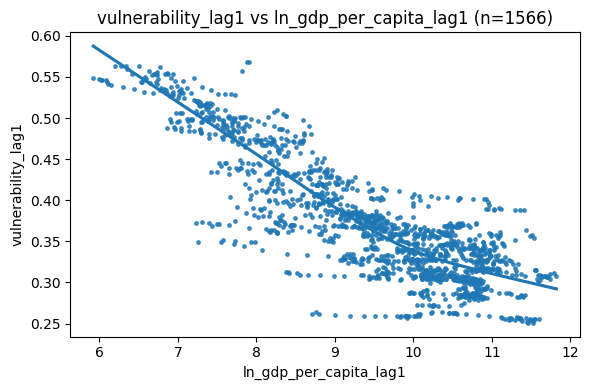

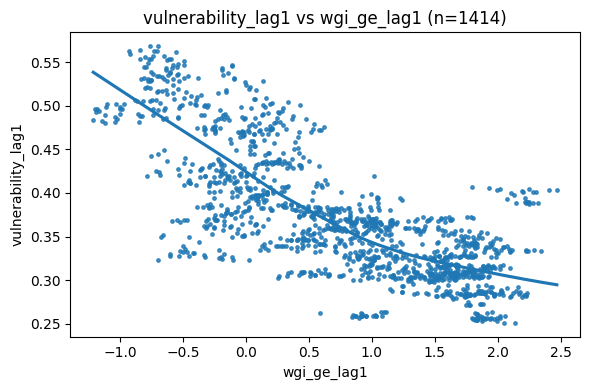

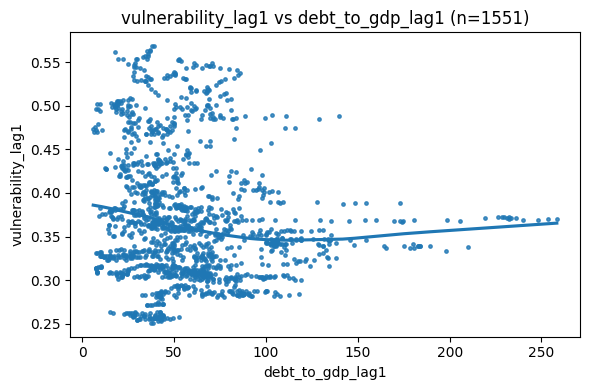

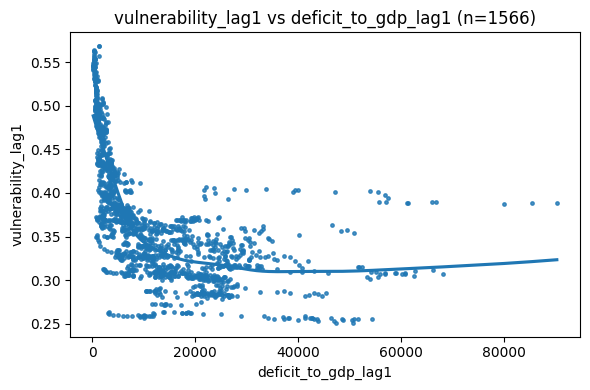

In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

suspects = ['ln_gdp_per_capita_lag1','wgi_ge_lag1', 'debt_to_gdp_lag1', 'deficit_to_gdp_lag1']
for c in suspects:
    if c not in df.columns:
        print(f"Skipping {c} (not in df)")
        continue

    # coerce & drop bad rows
    x = pd.to_numeric(df[c], errors='coerce')
    y = pd.to_numeric(df['vulnerability_lag1'], errors='coerce')
    mask = x.notna() & y.notna() & np.isfinite(x) & np.isfinite(y)
    n = mask.sum()
    if n < 10:
        print(f"Skipping {c}: too few valid observations ({n})")
        continue

    x_ = x[mask]
    y_ = y[mask]

    plt.figure(figsize=(6,4))
    try:
        # prefer LOWESS smoothing, but this may fail if statsmodels isn't available
        sns.regplot(x=x_, y=y_, lowess=True, scatter_kws={'s':6})
    except Exception as e:
        # fallback: linear trend only
        print(f"LOWESS failed for {c} (error: {e}). Falling back to linear fit.")
        sns.regplot(x=x_, y=y_, lowess=False, scatter_kws={'s':6})

    plt.xlabel(c)
    plt.ylabel('vulnerability_lag1')
    plt.title(f'vulnerability_lag1 vs {c} (n={n})')
    plt.tight_layout()
    plt.show()

In [19]:
import statsmodels.api as sm
controls = [c for c in ['ln_gdp_per_capita_lag1','debt_to_gdp_lag1','deficit_to_gdp_lag1','current_account_balance_lag1','cpi_yoy_lag1','gdp_annual_growth_rate_lag1'] if c in df.columns]
tmp = df.dropna(subset=['vulnerability_lag1'] + controls).copy()
Xc = sm.add_constant(tmp[controls].astype(float))
mdl = sm.OLS(tmp['vulnerability_lag1'], Xc).fit()
# residuals aligned to original index
df.loc[tmp.index, 'vul_resid'] = mdl.resid

# quick diagnostic
print("R^2 of vulnerability on controls:", mdl.rsquared)
print("Mean residual (should be ~0):", df['vul_resid'].mean())

# Now run DML with residualised treatment (exclude the controls you used to create the residual,
# because the treatment is already orthogonal to them — but you may keep them to be conservative)
covs_for_resid = [c for c in covariates_core if c not in controls]  # conservative choice: drop controls used in residual
out_resid = run_dml_loyo(df_local=df.dropna(subset=['vul_resid','sovereign_spread']),
                         covariates=covs_for_resid, idcol='iso3c', timecol='year',
                         ycol='sovereign_spread', tcol='vul_resid', n_trees=200, verbose=True)
print("Residualised DML theta:", out_resid['theta'], "SE:", getattr(out_resid['res'],'bse',[None])[0])

R^2 of vulnerability on controls: 0.6203443794672155
Mean residual (should be ~0): -1.1368789507687759e-13
Processed fold 0 hold_year=1996 (kept 14 rows).
Processed fold 5 hold_year=2001 (kept 32 rows).
Processed fold 10 hold_year=2006 (kept 38 rows).
Processed fold 15 hold_year=2011 (kept 46 rows).
Processed fold 20 hold_year=2016 (kept 54 rows).
Processed fold 25 hold_year=2021 (kept 55 rows).
LOYO DML done in 6.8s; theta=-0.127809; stacked rows=1260; folds used=29
Residualised DML theta: -0.12780923316502676 SE: 2.207704191217324


In [20]:
from sklearn.decomposition import PCA
pca_vars = [c for c in ['ln_gdp_per_capita_lag1','wgi_ge_lag1','debt_to_gdp_lag1','deficit_to_gdp_lag1','cpi_yoy_lag1','current_account_balance_lag1','gdp_annual_growth_rate_lag1'] if c in df.columns]
W = df[pca_vars].dropna()
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Wp = sc.fit_transform(W)
pca = PCA(n_components=1)
pc1 = pca.fit_transform(Wp)[:,0]
df.loc[W.index, 'dev_pc1'] = pc1

# add dev_pc1 into covariates (remove the original correlated vars)
covs_pca = [c for c in covariates_core if c not in pca_vars] + ['dev_pc1']
out_pca = run_dml_loyo(df_local=df.dropna(subset=['vulnerability_lag1','sovereign_spread']),
                       covariates=covs_pca, idcol='iso3c', timecol='year',
                       ycol='sovereign_spread', tcol='vulnerability_lag1', n_trees=200, verbose=True)
print("PCA DML theta:", out_pca['theta'], "SE:", getattr(out_pca['res'],'bse',[None])[0])

# Check VIF now for the compressed covariates (optional)
import numpy as np, pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
Xcheck = df[[c for c in covs_pca if c in df.columns]].dropna().apply(pd.to_numeric, errors='coerce').fillna(0)
vif_check = pd.Series([variance_inflation_factor(Xcheck.values, i) for i in range(Xcheck.shape[1])], index=Xcheck.columns)
print("VIF after PCA (top):\n", vif_check.sort_values(ascending=False).head(20))

Processed fold 0 hold_year=1996 (kept 32 rows).
Processed fold 5 hold_year=2001 (kept 42 rows).
Processed fold 10 hold_year=2006 (kept 48 rows).
Processed fold 15 hold_year=2011 (kept 56 rows).
Processed fold 20 hold_year=2016 (kept 64 rows).
Processed fold 25 hold_year=2021 (kept 66 rows).
LOYO DML done in 7.8s; theta=2.70659; stacked rows=1566; folds used=29
PCA DML theta: 2.7065919905395255 SE: 2.4913489449689035
VIF after PCA (top):
 ln_population_lag1     3.393521
ln_gross_gdp_lag1      3.286051
dev_pc1                1.293110
mineral_rent_lag1      1.065941
extreme_change_flag    1.005058
dtype: float64


### Trying PCA compression

In [21]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np, pandas as pd, os

def fit_attach_pca(df_local, cols, prefix, var_thresh=0.85, max_comps=3, out_dir="artifacts/pca_robustness"):
    """
    Robust PCA attachment:
     - Impute missing values (median) fit on rows with any non-missing data in `cols`.
     - Standardize and fit PCA on imputed data (limit components by max_comps and explained var).
     - Attach PC columns to df_local (NaN only if all cols were missing for that row).
     - If only one input column available, attach a standardized version as <prefix>_pc1.
    Returns:
      df_local (with new columns), pca_obj (or None), scaler_obj (or None), comp_cols (list)
    Side-effects: saves loadings CSV to out_dir if PCA fitted.
    """
    os.makedirs(out_dir, exist_ok=True)
    available = [c for c in cols if c in df_local.columns]
    if len(available) == 0:
        # nothing to do
        return df_local, None, None, []

    # define mask of rows that have at least one non-missing value among available cols
    mask_any = df_local[available].notna().any(axis=1)
    if mask_any.sum() == 0:
        # all missing -> no PCA possible
        return df_local, None, None, []

    # Build X_impute: rows with any non-missing are used to fit the imputer/scaler/PCA
    X_fit = df_local.loc[mask_any, available].astype(float)

    # 1) Impute with median (fit on rows with some data)
    imp = SimpleImputer(strategy='median')
    try:
        X_fit_imp = pd.DataFrame(imp.fit_transform(X_fit), columns=available, index=X_fit.index)
    except Exception as e:
        # if something goes wrong, return empty
        print("PCA imputer fit failed for", prefix, "error:", e)
        return df_local, None, None, []

    # 2) If only one variable effectively available, skip PCA and attach standardized col
    if X_fit_imp.shape[1] == 1:
        col = available[0]
        scaler = StandardScaler().fit(X_fit_imp.values.reshape(-1,1))
        # build full imputed column for all rows (transform using imputer then scaler)
        full_imp = pd.DataFrame(imp.transform(df_local[available].astype(float)), columns=available, index=df_local.index)
        scaled = scaler.transform(full_imp.values.reshape(-1,1)).ravel()
        pcname = f"{prefix}_pc1"
        df_local[pcname] = np.nan
        df_local.loc[:, pcname] = scaled
        # Optionally set rows where all original avail cols were NA to NaN (already imputed -> overwrite)
        df_local.loc[~df_local[available].notna().any(axis=1), pcname] = np.nan
        # create a dummy pca_obj for consistency? return None
        return df_local, None, scaler, [pcname]

    # 3) Standardize (fit scaler on imputed fit rows)
    scaler = StandardScaler().fit(X_fit_imp.values)
    Xs_fit = scaler.transform(X_fit_imp.values)

    # 4) Fit preliminary PCA to decide n_components by explained var (but limited by max_comps and dims)
    max_possible = min(max_comps, Xs_fit.shape[1])
    pca_pre = PCA(n_components=max_possible).fit(Xs_fit)
    cumvar = np.cumsum(pca_pre.explained_variance_ratio_)
    # choose smallest n where cumvar >= var_thresh (or at least 1)
    if cumvar.size == 0:
        n_comp = 1
    else:
        n_comp = int(np.searchsorted(cumvar, var_thresh) + 1)
        n_comp = min(max_possible, max(1, n_comp))

    # 5) Fit final PCA with n_comp
    pca = PCA(n_components=n_comp).fit(Xs_fit)

    # 6) build PCs for all rows: impute full df available cols then scale then transform
    full_imp = pd.DataFrame(imp.transform(df_local[available].astype(float)), columns=available, index=df_local.index)
    Xs_full = scaler.transform(full_imp.values)
    comps_full = pca.transform(Xs_full)  # shape (n_rows, n_comp)

    comp_cols = [f"{prefix}_pc{i+1}" for i in range(n_comp)]
    for i, colname in enumerate(comp_cols):
        df_local[colname] = np.nan
        df_local.loc[:, colname] = comps_full[:, i]

    # set PC entries to NaN for rows that had all original available columns missing
    rows_all_missing = ~df_local[available].notna().any(axis=1)
    if rows_all_missing.any():
        df_local.loc[rows_all_missing, comp_cols] = np.nan

    # save loadings and explained variance for inspection
    loadings = pd.DataFrame(pca.components_.T, index=available, columns=comp_cols)
    loadings['explained_var_ratio_pc'] = np.nan  # placeholder, we save separately below
    loadings.to_csv(os.path.join(out_dir, f"{prefix}_loadings.csv"))
    # save explained variance
    ev = pd.Series(pca.explained_variance_ratio_, index=comp_cols)
    ev.to_csv(os.path.join(out_dir, f"{prefix}_explained_variance_ratio.csv"))

    return df_local, pca, scaler, comp_cols

In [55]:
# 1. define which variables to compress
pca_variants = {
    'pca_gdp': [c for c in ['ln_gdp_per_capita_lag1','gdp_annual_growth_rate_lag1'] if c in df.columns],
    'pca_debtfiscal': [c for c in ['debt_to_gdp_lag1','deficit_to_gdp_lag1','current_account_balance_lag1'] if c in df.columns],
    'pca_wgi': [c for c in ['wgi_ge_lag1','wgi_rl_lag1','wgi_cc_lag1','wgi_pv_lag1','wgi_rq_lag1','wgi_va_lag1'] if c in df.columns],
    'pca_all': [c for c in ['ln_gdp_per_capita_lag1','gdp_annual_growth_rate_lag1','debt_to_gdp_lag1','deficit_to_gdp_lag1','current_account_balance_lag1',
                             'wgi_ge_lag1','wgi_rl_lag1','wgi_cc_lag1','wgi_pv_lag1','wgi_rq_lag1','wgi_va_lag1'] if c in df.columns]
}

pca_info = {}
for name, cols in pca_variants.items():
    df, pca_obj, scaler_obj, comp_cols = fit_attach_pca(df, cols, prefix=name, var_thresh=0.85, max_comps=3, out_dir="artifacts/pca_robustness")
    pca_info[name] = {'cols': cols, 'pca': pca_obj, 'scaler': scaler_obj, 'comp_cols': comp_cols}
    print(f"{name}: input_cols={cols} -> comp_cols={comp_cols}")

pca_gdp: input_cols=['ln_gdp_per_capita_lag1', 'gdp_annual_growth_rate_lag1'] -> comp_cols=['pca_gdp_pc1', 'pca_gdp_pc2']
pca_debtfiscal: input_cols=['debt_to_gdp_lag1', 'deficit_to_gdp_lag1', 'current_account_balance_lag1'] -> comp_cols=['pca_debtfiscal_pc1', 'pca_debtfiscal_pc2', 'pca_debtfiscal_pc3']
pca_wgi: input_cols=['wgi_ge_lag1', 'wgi_rl_lag1', 'wgi_cc_lag1', 'wgi_pv_lag1', 'wgi_rq_lag1'] -> comp_cols=['pca_wgi_pc1']
pca_all: input_cols=['ln_gdp_per_capita_lag1', 'gdp_annual_growth_rate_lag1', 'debt_to_gdp_lag1', 'deficit_to_gdp_lag1', 'current_account_balance_lag1', 'wgi_ge_lag1', 'wgi_rl_lag1', 'wgi_cc_lag1', 'wgi_pv_lag1', 'wgi_rq_lag1'] -> comp_cols=['pca_all_pc1', 'pca_all_pc2', 'pca_all_pc3']


In [56]:
# show first few rows of every PC column produced
pc_cols_all = [c for info in pca_info.values() for c in info.get('comp_cols', [])]
print("All PC cols:", pc_cols_all)
display(df[pc_cols_all].head(8))

# quick summary stats and missingness for each PC
print(df[pc_cols_all].describe().T[['mean','std','min','max']])
print("Missingness (per PC):")
print(df[pc_cols_all].isna().sum())

All PC cols: ['pca_gdp_pc1', 'pca_gdp_pc2', 'pca_debtfiscal_pc1', 'pca_debtfiscal_pc2', 'pca_debtfiscal_pc3', 'pca_wgi_pc1', 'pca_all_pc1', 'pca_all_pc2', 'pca_all_pc3']


,pca_gdp_pc1,pca_gdp_pc2,pca_debtfiscal_pc1,pca_debtfiscal_pc2,pca_debtfiscal_pc3,pca_wgi_pc1,pca_all_pc1,pca_all_pc2,pca_all_pc3
0,-1.462571,-1.991409,-0.298746,-0.143669,-0.650506,-2.826135,-2.674066,-1.875595,1.131490
1,0.617341,0.566091,-0.643012,-0.399023,-0.087234,-2.361221,-2.459649,0.630669,0.237075
2,-0.794490,-0.753435,-0.533514,-0.398783,-0.134174,-2.631789,-2.489317,-0.742868,0.588770
3,-0.184351,-0.096146,-0.678908,-0.218048,0.052831,-2.702121,-2.635967,-0.252803,0.326410
4,-1.080824,-1.095902,-0.649887,-0.214064,-0.045331,-2.891196,-2.724163,-1.200773,0.573869
5,-0.131024,-0.011922,-0.657386,0.051964,0.071789,-2.712984,-2.628697,-0.376823,0.314974
6,-0.968748,-1.021303,-0.708122,0.067130,0.006418,-1.842730,-1.815418,-1.205041,0.094555
7,-0.095981,0.002160,-0.848550,0.289158,0.259516,-1.780430,-1.842057,-0.425593,-0.283365


                            mean       std       min       max
pca_gdp_pc1         1.814924e-17  1.098992 -3.448638  3.376682
pca_gdp_pc2         0.000000e+00  0.890783 -4.687898  5.126393
pca_debtfiscal_pc1  4.537310e-17  1.226998 -3.402320  6.896985
pca_debtfiscal_pc2  3.629848e-17  0.989683 -2.703344  5.047449
pca_debtfiscal_pc3  3.629848e-17  0.718971 -2.400010  3.819429
pca_wgi_pc1        -8.040088e-17  2.138599 -4.688442  3.375991
pca_all_pc1         7.259696e-17  2.469367 -5.405809  6.129614
pca_all_pc2        -3.629848e-17  1.079521 -5.555099  4.350922
pca_all_pc3         0.000000e+00  1.004379 -3.864527  4.974785
Missingness (per PC):
pca_gdp_pc1             0
pca_gdp_pc2             0
pca_debtfiscal_pc1      0
pca_debtfiscal_pc2      0
pca_debtfiscal_pc3      0
pca_wgi_pc1           152
pca_all_pc1             0
pca_all_pc2             0
pca_all_pc3             0
dtype: int64


In [57]:
# choose treatment col (lagged vulnerability)
tcol_test = 'vulnerability_lag1' if 'vulnerability_lag1' in df.columns else 'vulnerability'

# build a minimal covariate list: replace the original set of highly collinear covariates with the PC1
info = pca_info.get('pca_all', {})
pc1 = info.get('comp_cols', [None])[0]
if pc1 is None:
    raise RuntimeError("pca_all didn't create a PC1 — abort quick test and inspect pca_info")

covs_test = [c for c in covariates_core if c not in info.get('cols', [])] + [pc1]
covs_test = [c for c in covs_test if c in df.columns]
print("Running quick DML test with covariates:", covs_test)

df_run = df.dropna(subset=[tcol_test, 'sovereign_spread']).reset_index(drop=True)
out_quick = run_dml_loyo(df_local=df_run, covariates=covs_test, idcol='iso3c', timecol='year',
                         ycol='sovereign_spread', tcol=tcol_test, n_trees=200, random_seed=2025, verbose=True)
print("Quick DML result:", out_quick.get('theta'), getattr(out_quick.get('res'), 'bse', [None])[0],
      getattr(out_quick.get('res'), 'pvalues', [None])[0])

Running quick DML test with covariates: ['cpi_yoy_lag1', 'extreme_change_flag', 'pca_all_pc1']
Processed fold 0 hold_year=1996 (kept 32 rows).
Processed fold 5 hold_year=2001 (kept 42 rows).
Processed fold 10 hold_year=2006 (kept 48 rows).
Processed fold 15 hold_year=2011 (kept 56 rows).
Processed fold 20 hold_year=2016 (kept 64 rows).
Processed fold 25 hold_year=2021 (kept 66 rows).
LOYO DML done in 8.7s; theta=2.89401; stacked rows=1566; folds used=29
Quick DML result: 2.8940060290509466 4.848160977480034 0.5505550400170423


In [22]:
# === PCA-based robustness and table output (fixed for NaNs) ===
import os, numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.impute import SimpleImputer

out_dir = "artifacts/pca_robustness"
os.makedirs(out_dir, exist_ok=True)

# --- 1. choose variables to compress (adjust to your df) ---
gdp_vars = [c for c in ['ln_gdp_per_capita_lag1','gdp_annual_growth_rate_lag1'] if c in df.columns]
debt_fiscal_vars = [c for c in ['debt_to_gdp_lag1','deficit_to_gdp_lag1','current_account_balance_lag1'] if c in df.columns]
wgi_vars = [c for c in ['wgi_ge_lag1','wgi_rl_lag1','wgi_cc_lag1','wgi_pv_lag1','wgi_rq_lag1','wgi_va_lag1'] if c in df.columns]

pca_variants = {
    'pca_gdp': gdp_vars,
    'pca_debtfiscal': debt_fiscal_vars,
    'pca_wgi': wgi_vars,
    'pca_all': gdp_vars + debt_fiscal_vars + wgi_vars
}

def fit_attach_pca(df_local, cols, prefix, var_thresh=0.85, max_comps=3):
    """
    Fit PCA on the selected cols (imputes missing values with column median),
    attach PC columns to df_local, and return (df_local, pca_object, scaler_object, comp_cols, avail_cols).
    """
    avail = [c for c in cols if c in df_local.columns]
    if len(avail) == 0:
        if len(cols) > 0:
            print(f"[fit_attach_pca] none of requested cols present for prefix={prefix}: {cols}")
        return df_local, None, None, [], []
    # Take the subset and impute missing with median (fit imputer on these cols)
    X = df_local[avail].astype(float)
    imputer = SimpleImputer(strategy='median')
    X_imp = pd.DataFrame(imputer.fit_transform(X), columns=avail, index=X.index)
    # standardize
    scaler = StandardScaler().fit(X_imp.values)
    Xs = scaler.transform(X_imp.values)
    # PCA fitting: choose up to max_comps but not more than number of input features
    n_features = Xs.shape[1]
    n_try = min(max_comps, n_features) if n_features > 0 else 0
    if n_try <= 0:
        return df_local, None, scaler, [], avail
    pca_full = PCA(n_components=n_try).fit(Xs)
    cumvar = np.cumsum(pca_full.explained_variance_ratio_)
    # choose number of components to reach var_thresh (at least 1)
    if cumvar.size > 0:
        n_comp = int(np.searchsorted(cumvar, var_thresh) + 1)
    else:
        n_comp = 1
    n_comp = min(max(1, n_comp), n_try)
    pca = PCA(n_components=n_comp).fit(Xs)
    comps = pca.transform(Xs)  # shape: (n_obs, n_comp)
    comp_cols = [f"{prefix}_pc{i+1}" for i in range(n_comp)]
    # attach to df_local: compute PCs for all rows using the imputer+scaler+pca transformation
    # (we already used the imputer on all rows above)
    for i, col in enumerate(comp_cols):
        df_local[col] = np.nan
        df_local.loc[X_imp.index, col] = comps[:, i]
    # save explained variance info for later inspection
    evr = pd.Series(pca.explained_variance_ratio_, index=comp_cols)
    evr.to_csv(os.path.join(out_dir, f"{prefix}_explained_variance_ratio.csv"))
    # save loadings using the actual available columns
    loadings = pd.DataFrame(pca.components_.T, index=avail, columns=comp_cols)
    loadings.to_csv(os.path.join(out_dir, f"{prefix}_loadings.csv"))
    return df_local, pca, scaler, comp_cols, avail

# Fit PCA variants and collect loadings/info
pca_info = {}
for name, cols in pca_variants.items():
    df, pca_obj, scaler_obj, comp_cols, avail_cols = fit_attach_pca(df, cols, prefix=name, var_thresh=0.85, max_comps=3)
    pca_info[name] = {'requested_cols': cols, 'avail_cols': avail_cols, 'pca': pca_obj, 'scaler': scaler_obj, 'comp_cols': comp_cols}
    if pca_obj is None:
        print(f"[PCA] variant {name} produced no components (avail_cols={avail_cols}).")
    else:
        print(f"[PCA] variant {name}: avail={avail_cols} -> comps={comp_cols}")

# --- 2. define DML specs using PCA components ---
specs = []
# baseline covariates: replace original pca input groups with PC columns
for name, info in pca_info.items():
    comp_cols = info['comp_cols']
    avail_cols = info['avail_cols']
    if len(comp_cols) == 0:
        continue
    # a) PC1 only
    covs_pc1 = [c for c in covariates_core if c not in info['avail_cols']] + [comp_cols[0]]
    covs_pc1 = [c for c in covs_pc1 if c in df.columns]
    specs.append({'name': f"{name}_pc1", 'covs': covs_pc1})
    # b) PC1 + PC2 (if present)
    if len(comp_cols) >= 2:
        covs_pc12 = [c for c in covariates_core if c not in info['avail_cols']] + comp_cols[:2]
        covs_pc12 = [c for c in covs_pc12 if c in df.columns]
        specs.append({'name': f"{name}_pc12", 'covs': covs_pc12})

# optional: residualised treatment spec (if you precomputed it)
if 'vul_resid' in df.columns:
    specs.append({'name': 'resid_vul', 'covs': covariates_core})

# Additional specs: mundlak (add country means), include/exclude BGR event variants
if 'bgr_hist_event' in df.columns:
    base_specs = specs.copy()
    for s in base_specs:
        covs_with_event = s['covs'] + ['bgr_hist_event']
        covs_with_event = [c for c in covs_with_event if c in df.columns]
        specs.append({'name': s['name'] + '_wEvent', 'covs': covs_with_event})

# ensure specs with non-empty cov lists only
specs = [s for s in specs if len(s['covs'])>0]

# --- 3. run DML per spec and capture results ---
results = []
for s in specs:
    name = s['name']
    covs = s['covs']
    print("Running spec:", name)
    # decide treatment column
    if name.startswith('resid_vul'):
        tcol = 'vul_resid'
    else:
        tcol = 'vulnerability_lag1' if 'vulnerability_lag1' in df.columns else 'vulnerability'
    try:
        df_run = df.dropna(subset=[tcol, 'sovereign_spread']).reset_index(drop=True)
        out = run_dml_loyo(df_local=df_run, covariates=covs,
                           idcol='iso3c', timecol='year', ycol='sovereign_spread', tcol=tcol,
                           n_trees=200, random_seed=2025, verbose=False)
        theta = out.get('theta', np.nan)
        res = out.get('res', None)
        se = getattr(res, 'bse', [np.nan])[0] if res is not None else np.nan
        pval = getattr(res, 'pvalues', [np.nan])[0] if res is not None else np.nan
        n_rows = 0 if out.get('u_all') is None else len(out['u_all'])
        folds_used = out.get('diag', pd.DataFrame()).shape[0]
        m_med = np.nanmedian(out.get('m_oos_r2_folds') or [np.nan])
        p_med = np.nanmedian(out.get('p_oos_r2_folds') or [np.nan])
        # quick wild cluster bootstrap (works on stacked residuals; may be slow)
        try:
            uu = out.get('u_all'); vv = out.get('v_all'); groups = out.get('groups')
            if uu is not None:
                def wild_boot_pval(uu,vv,groups,B=299,seed=2025):
                    np.random.seed(seed)
                    gs = pd.Index(groups.unique())
                    gidx = {g: np.where(groups==g)[0] for g in gs}
                    T0 = (vv*uu).sum()/(vv**2).sum()
                    boots=[]
                    for b in range(B):
                        eps_g = np.random.choice([-1,1], size=len(gs))
                        eps = np.zeros(len(groups)); 
                        for i,g in enumerate(gs): eps[gidx[g]] = eps_g[i]
                        uu_b = uu.values * eps
                        tb = (vv*uu_b).sum()/(vv**2).sum()
                        boots.append(tb)
                    boots=np.array(boots)
                    p_two = (np.sum(np.abs(boots) >= np.abs(T0))+1)/(B+1)
                    return float(p_two)
                p_wild = wild_boot_pval(uu, vv, groups, B=299)
            else:
                p_wild = np.nan
        except Exception:
            p_wild = np.nan

        results.append({'spec': name, 'theta': theta, 'se': se, 'pval': pval, 'p_wild': p_wild,
                        'n_rows': n_rows, 'folds_used': folds_used, 'm_oos_r2_med': m_med, 'p_oos_r2_med': p_med})
        pd.DataFrame([results[-1]]).to_csv(os.path.join(out_dir, f"{name}_summary.csv"), index=False)
        print("  OK:", name, "theta:", theta, "se:", se, "p_wild:", p_wild)
    except Exception as e:
        print("  FAILED spec:", name, "error:", repr(e))
        results.append({'spec': name, 'theta': np.nan, 'se': np.nan, 'pval': np.nan, 'p_wild': np.nan,
                        'n_rows': np.nan, 'folds_used': np.nan, 'm_oos_r2_med': np.nan, 'p_oos_r2_med': np.nan})
        pd.DataFrame([results[-1]]).to_csv(os.path.join(out_dir, f"{name}_summary_failed.csv"), index=False)

# --- 4. build the user-facing result table and LaTeX ---
res_df = pd.DataFrame(results)
v_std = df['vulnerability_lag1'].std() if 'vulnerability_lag1' in df.columns else (df['vulnerability'].std() if 'vulnerability' in df.columns else 1.0)
res_df['theta_per_sd'] = res_df['theta'] * v_std
res_df['theta_bps_per_unit'] = res_df['theta'] * 100.0
res_df['theta_bps_per_sd'] = res_df['theta_per_sd'] * 100.0

table_cols = ['spec','theta','se','pval','p_wild','theta_per_sd','theta_bps_per_unit','theta_bps_per_sd','n_rows','folds_used','m_oos_r2_med','p_oos_r2_med']
res_df = res_df[table_cols]
res_df.to_csv(os.path.join(out_dir,'pca_robustness_results.csv'), index=False)

def stars(p):
    if pd.isna(p): return ''
    if p < 0.01: return '^{***}'
    if p < 0.05: return '^{**}'
    if p < 0.1: return '^{*}'
    return ''

latex_df = res_df.copy()
latex_df['theta_label'] = latex_df.apply(lambda r: f"{r['theta']:.3f}{stars(r['pval'])}", axis=1)
latex_df['se_label'] = latex_df['se'].apply(lambda x: f"({x:.3f})" if pd.notna(x) else '')
latex_out = latex_df[['spec','theta_label','se_label','theta_per_sd','theta_bps_per_unit','theta_bps_per_sd','n_rows','folds_used']]
latex_out = latex_out.rename(columns={
    'spec':'Specification','theta_label':'Estimate','se_label':'(Cluster SE)','theta_per_sd':'Est per SD','theta_bps_per_unit':'Est (bps/unit)','theta_bps_per_sd':'Est (bps/SD)'
})
with open(os.path.join(out_dir,'pca_robustness_table.tex'),'w') as f:
    f.write(latex_out.to_latex(index=False, escape=False, caption="PCA-based DML robustness: estimates, clustered SEs in parentheses. Stars indicate p-value significance.", label="tab:pca_robustness"))

print("Saved pca robustness CSV and LaTeX to", out_dir)

[PCA] variant pca_gdp: avail=['ln_gdp_per_capita_lag1', 'gdp_annual_growth_rate_lag1'] -> comps=['pca_gdp_pc1', 'pca_gdp_pc2']
[PCA] variant pca_debtfiscal: avail=['debt_to_gdp_lag1', 'deficit_to_gdp_lag1', 'current_account_balance_lag1'] -> comps=['pca_debtfiscal_pc1', 'pca_debtfiscal_pc2', 'pca_debtfiscal_pc3']
[PCA] variant pca_wgi: avail=['wgi_ge_lag1', 'wgi_rl_lag1', 'wgi_cc_lag1', 'wgi_pv_lag1', 'wgi_rq_lag1'] -> comps=['pca_wgi_pc1']
[PCA] variant pca_all: avail=['ln_gdp_per_capita_lag1', 'gdp_annual_growth_rate_lag1', 'debt_to_gdp_lag1', 'deficit_to_gdp_lag1', 'current_account_balance_lag1', 'wgi_ge_lag1', 'wgi_rl_lag1', 'wgi_cc_lag1', 'wgi_pv_lag1', 'wgi_rq_lag1'] -> comps=['pca_all_pc1', 'pca_all_pc2', 'pca_all_pc3']
Running spec: pca_gdp_pc1
  OK: pca_gdp_pc1 theta: 2.766809590855464 se: 2.507568931503266 p_wild: 0.2966666666666667
Running spec: pca_gdp_pc12
  OK: pca_gdp_pc12 theta: -5.27424498028354 se: 8.254578617724144 p_wild: 0.7166666666666667
Running spec: pca_debtfis

In [14]:
# ----------------------------
# Fold-wise PCA + LOYO DML cell
# Paste this entire cell BEFORE running analysis
# ----------------------------
import os, time, numpy as np, pandas as pd
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, LogisticRegressionCV, Lasso
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# ----------------------------
# 1) Create z-scored treatment (global standardization)
# ----------------------------
treatment = 'vulnerability_lag1'
zname = treatment + '_z'
if treatment not in df.columns:
    raise ValueError(f"{treatment} not found in df columns. Create lag first (df.groupby('iso3c')['vulnerability'].shift(1)).")
df[zname] = (df[treatment] - df[treatment].mean()) / (df[treatment].std(ddof=0) if df[treatment].std(ddof=0) != 0 else 1.0)
print(f"Created standardized treatment column: {zname} (mean {df[zname].mean():.3g}, sd {df[zname].std():.3g})")

# ----------------------------
# 2) run_dml_loyo_foldwise_pca function
# ----------------------------
def run_dml_loyo_foldwise_pca(df_local,
                              covariates,
                              pca_vars=None,
                              n_pcs=1,
                              idcol='iso3c',
                              timecol='year',
                              ycol='sovereign_spread',
                              tcol=zname,
                              n_trees=200,
                              random_seed=2025,
                              min_train_rows=10,
                              use_knn=True,
                              verbose=True):
    """
    LOYO Double ML with fold-wise imputation/scaling/PCA for supplied pca_vars.
    - pca_vars: list of covariates to compress via PCA (will be replaced by their PCs in-fold).
    - n_pcs: number of principal components to keep (1 recommended).
    Returns same dict structure as previous run_dml_loyo.
    """
    np.random.seed(random_seed)
    years = sorted(df_local[timecol].dropna().unique())
    u_list=[]; v_list=[]; groups_list=[]; diag=[]
    p_oos_r2_folds=[]; m_oos_r2_folds=[]
    fold_used = 0
    t0 = time.time()

    covs_present_global = [c for c in covariates if c in df_local.columns]
    pca_vars = [c for c in (pca_vars or []) if c in df_local.columns]
    other_covs_global = [c for c in covs_present_global if c not in pca_vars]

    if len(covs_present_global) == 0:
        raise ValueError("No covariates found in df_local from provided covariates list.")

    for fnum, hold_year in enumerate(years):
        # split train/test
        train = df_local[df_local[timecol] != hold_year].reset_index(drop=True).copy()
        test  = df_local[df_local[timecol] == hold_year].reset_index(drop=True).copy()

        if train.shape[0] == 0 or test.shape[0] == 0:
            if verbose:
                print(f"Fold {fnum} year {hold_year}: empty train/test, skip")
            continue

        # Prepare training covariates: we'll operate separately on pca_vars and other_covs
        # Coerce numeric where possible
        Xtr_pca = train[pca_vars].apply(pd.to_numeric, errors='coerce') if len(pca_vars)>0 else pd.DataFrame(index=train.index)
        Xte_pca = test[pca_vars].apply(pd.to_numeric, errors='coerce') if len(pca_vars)>0 else pd.DataFrame(index=test.index)
        Xtr_oth = train[other_covs_global].apply(pd.to_numeric, errors='coerce') if len(other_covs_global)>0 else pd.DataFrame(index=train.index)
        Xte_oth = test[other_covs_global].apply(pd.to_numeric, errors='coerce') if len(other_covs_global)>0 else pd.DataFrame(index=test.index)

        # Impute on TRAIN only for pca_vars and other covs
        try:
            if use_knn:
                imp_pca = KNNImputer(n_neighbors=5)
                imp_oth = KNNImputer(n_neighbors=5) if Xtr_oth.shape[1]>0 else None
            else:
                imp_pca = SimpleImputer(strategy='median')
                imp_oth = SimpleImputer(strategy='median') if Xtr_oth.shape[1]>0 else None

            if Xtr_pca.shape[1] > 0:
                Xtr_pca_imp = pd.DataFrame(imp_pca.fit_transform(Xtr_pca), columns=Xtr_pca.columns, index=Xtr_pca.index)
                Xte_pca_imp = pd.DataFrame(imp_pca.transform(Xte_pca), columns=Xte_pca.columns, index=Xte_pca.index)
            else:
                Xtr_pca_imp = pd.DataFrame(index=Xtr_pca.index)
                Xte_pca_imp = pd.DataFrame(index=Xte_pca.index)

            if Xtr_oth.shape[1] > 0:
                Xtr_oth_imp = pd.DataFrame(imp_oth.fit_transform(Xtr_oth), columns=Xtr_oth.columns, index=Xtr_oth.index)
                Xte_oth_imp = pd.DataFrame(imp_oth.transform(Xte_oth), columns=Xte_oth.columns, index=Xte_oth.index)
            else:
                Xtr_oth_imp = pd.DataFrame(index=Xtr_oth.index)
                Xte_oth_imp = pd.DataFrame(index=Xte_oth.index)
        except Exception:
            # fallback to median fill
            if Xtr_pca.shape[1] > 0:
                Xtr_pca_imp = Xtr_pca.fillna(Xtr_pca.median())
                Xte_pca_imp = Xte_pca.fillna(Xtr_pca.median())
            else:
                Xtr_pca_imp = pd.DataFrame(index=Xtr_pca.index); Xte_pca_imp = pd.DataFrame(index=Xte_pca.index)
            if Xtr_oth.shape[1] > 0:
                Xtr_oth_imp = Xtr_oth.fillna(Xtr_oth.median())
                Xte_oth_imp = Xte_oth.fillna(Xtr_oth.median())
            else:
                Xtr_oth_imp = pd.DataFrame(index=Xtr_oth.index); Xte_oth_imp = pd.DataFrame(index=Xte_oth.index)

        # Scale on TRAIN only
        if Xtr_pca_imp.shape[1] > 0:
            sc_pca = StandardScaler().fit(Xtr_pca_imp.values)
            Xtr_pca_s = pd.DataFrame(sc_pca.transform(Xtr_pca_imp.values), columns=Xtr_pca_imp.columns, index=Xtr_pca_imp.index)
            Xte_pca_s = pd.DataFrame(sc_pca.transform(Xte_pca_imp.values), columns=Xte_pca_imp.columns, index=Xte_pca_imp.index)
        else:
            Xtr_pca_s = pd.DataFrame(index=Xtr_pca_imp.index); Xte_pca_s = pd.DataFrame(index=Xte_pca_imp.index)

        if Xtr_oth_imp.shape[1] > 0:
            sc_oth = StandardScaler().fit(Xtr_oth_imp.values)
            Xtr_oth_s = pd.DataFrame(sc_oth.transform(Xtr_oth_imp.values), columns=Xtr_oth_imp.columns, index=Xtr_oth_imp.index)
            Xte_oth_s = pd.DataFrame(sc_oth.transform(Xte_oth_imp.values), columns=Xte_oth_imp.columns, index=Xte_oth_imp.index)
        else:
            Xtr_oth_s = pd.DataFrame(index=Xtr_oth_imp.index); Xte_oth_s = pd.DataFrame(index=Xte_oth_imp.index)

        # PCA fit on TRAIN only (if pca_vars exist)
        pc_cols = []
        if Xtr_pca_s.shape[1] > 0:
            n_comp_use = min(n_pcs, Xtr_pca_s.shape[1])
            pca = PCA(n_components=n_comp_use, random_state=random_seed).fit(Xtr_pca_s.values)
            comps_tr = pca.transform(Xtr_pca_s.values)
            comps_te = pca.transform(Xte_pca_s.values)
            pc_cols = [f"foldpc_{fnum}_{i+1}" for i in range(n_comp_use)]
            # Build DataFrames for PCs aligned to train/test indexes
            Xtr_pcs = pd.DataFrame(comps_tr, columns=pc_cols, index=Xtr_pca_s.index)
            Xte_pcs = pd.DataFrame(comps_te, columns=pc_cols, index=Xte_pca_s.index)
        else:
            Xtr_pcs = pd.DataFrame(index=Xtr_pca_s.index); Xte_pcs = pd.DataFrame(index=Xte_pca_s.index)

        # Combine all covariates for this fold: other scaled covs + PCs (year dummies added below)
        Xtrain_full = pd.concat([Xtr_oth_s.reset_index(drop=True), Xtr_pcs.reset_index(drop=True)], axis=1)
        Xtest_full  = pd.concat([Xte_oth_s.reset_index(drop=True), Xte_pcs.reset_index(drop=True)], axis=1)

        # Year dummies: align test to train
        yrs_tr = pd.get_dummies(train[timecol], prefix='yr').reset_index(drop=True)
        yrs_te = pd.get_dummies(test[timecol], prefix='yr').reindex(columns=yrs_tr.columns, fill_value=0).reset_index(drop=True)
        Xtrain_full = pd.concat([Xtrain_full.reset_index(drop=True), yrs_tr], axis=1)
        Xtest_full  = pd.concat([Xtest_full.reset_index(drop=True), yrs_te], axis=1)
        Xtest_full = Xtest_full.reindex(columns=Xtrain_full.columns, fill_value=0)

        # Prepare y and t (coerce numeric)
        ytr = pd.to_numeric(train[ycol], errors='coerce') if ycol in train.columns else pd.Series(np.nan, index=train.index)
        yte = pd.to_numeric(test[ycol], errors='coerce') if ycol in test.columns else pd.Series(np.nan, index=test.index)
        ttr = pd.to_numeric(train[tcol], errors='coerce') if tcol in train.columns else pd.Series(np.nan, index=train.index)
        tte = pd.to_numeric(test[tcol], errors='coerce') if tcol in test.columns else pd.Series(np.nan, index=test.index)

        # Require enough non-missing y & t in train
        train_mask = (~ytr.isna()) & (~ttr.isna())
        if train_mask.sum() < min_train_rows:
            if verbose:
                print(f"Fold {fnum} year {hold_year}: insufficient train rows with y&t: {train_mask.sum()} < {min_train_rows}; skipping")
            continue
        pos = np.where(train_mask)[0]
        Xtrain_sub = Xtrain_full.iloc[pos, :].copy()
        ytrain_sub = ytr.iloc[pos].astype(float).copy()
        ttrain_sub = ttr.iloc[pos].astype(float).copy()

        # ensure variation in t in train
        if np.nanvar(ttrain_sub.to_numpy()) == 0:
            if verbose:
                print(f"Fold {fnum} year {hold_year}: no variation in t in train; skipping")
            continue

        # Fit p-model (Lasso or Logistic)
        unique_t = pd.Series(ttrain_sub.dropna().unique())
        is_binary_t = (unique_t.nunique() == 2) and set(unique_t.unique()).issubset({0,1})
        try:
            if is_binary_t:
                p_model = LogisticRegressionCV(cv=5, random_state=random_seed, max_iter=5000).fit(Xtrain_sub, ttrain_sub)
                p_hat_test = p_model.predict_proba(Xtest_full)[:,1]
            else:
                p_model = LassoCV(cv=5, random_state=random_seed).fit(Xtrain_sub, ttrain_sub)
                p_hat_test = p_model.predict(Xtest_full)
        except Exception:
            p_model = Lasso(max_iter=20000).fit(Xtrain_sub, ttrain_sub)
            p_hat_test = p_model.predict(Xtest_full)

        # Fit m-model (RF) with OLS fallback
        try:
            m_model = RandomForestRegressor(n_estimators=n_trees, random_state=random_seed, n_jobs=-1).fit(Xtrain_sub, ytrain_sub)
            m_hat_test = m_model.predict(Xtest_full)
        except Exception:
            m_ols = sm.OLS(ytrain_sub.values, sm.add_constant(Xtrain_sub)).fit()
            m_model = m_ols
            m_hat_test = m_ols.predict(sm.add_constant(Xtest_full))

        # Collect only test rows with non-missing y & t
        test_mask = (~yte.isna()) & (~tte.isna())
        if test_mask.sum() == 0:
            if verbose:
                print(f"Fold {fnum} year {hold_year}: no test rows with both y and t; skip collecting")
            continue
        test_pos = np.where(test_mask)[0]
        t_test_vals = tte.to_numpy()[test_pos].astype(float)
        y_test_vals = yte.to_numpy()[test_pos].astype(float)
        p_pred_vals = np.asarray(p_hat_test)[test_pos]
        m_pred_vals = np.asarray(m_hat_test)[test_pos]

        # OOS R2s
        def safe_oos_r2(y_true, y_pred):
            ss_res = np.nansum((y_true - y_pred)**2)
            ss_tot = np.nansum((y_true - np.nanmean(y_true))**2)
            if ss_tot == 0:
                return np.nan
            return 1.0 - ss_res / ss_tot

        p_oos_r2 = safe_oos_r2(t_test_vals, p_pred_vals)
        m_oos_r2 = safe_oos_r2(y_test_vals, m_pred_vals)
        p_oos_r2_folds.append(p_oos_r2)
        m_oos_r2_folds.append(m_oos_r2)

        # residuals
        v_hat = t_test_vals - p_pred_vals
        u_hat = y_test_vals - m_pred_vals

        base = fnum * 10**6
        idxs = [base + i for i in range(len(u_hat))]
        u_list.append(pd.Series(u_hat, index=idxs))
        v_list.append(pd.Series(v_hat, index=idxs))
        groups_list.append(pd.Series(test.loc[test_pos, idcol].values, index=idxs))

        diag.append({'fold': fnum, 'year_holdout': hold_year, 'n_train': len(train), 'n_test': len(test),
                     'n_kept': len(u_hat), 'p_oos_r2': p_oos_r2, 'm_oos_r2': m_oos_r2})
        fold_used += 1
        if verbose and (fnum % 5 == 0):
            print(f"Processed fold {fnum} hold_year={hold_year} (kept {len(u_hat)} rows).")

    # aggregate
    if len(u_list) == 0:
        if verbose:
            print("No usable folds found. Returning NaNs.")
        return {'theta': np.nan, 'res': None, 'u_all': None, 'v_all': None, 'groups': None, 'diag': pd.DataFrame(diag),
                'p_oos_r2_folds': p_oos_r2_folds, 'm_oos_r2_folds': m_oos_r2_folds}

    u_all = pd.concat(u_list).sort_index()
    v_all = pd.concat(v_list).sort_index()
    groups = pd.concat(groups_list).sort_index()

    theta = (v_all * u_all).sum() / (v_all ** 2).sum()
    exog = np.asarray(v_all).reshape(-1,1)
    endog = np.asarray(u_all)
    try:
        ols_final = sm.OLS(endog, exog).fit(cov_type='cluster', cov_kwds={'groups': groups.values})
    except Exception:
        ols_final = sm.OLS(endog, exog).fit(cov_type='HC1')

    elapsed = time.time() - t0
    if verbose:
        print(f"LOYO DML done in {elapsed:.1f}s; theta={theta:.6g}; stacked rows={len(u_all)}; folds used={fold_used}")
    return {'theta': float(theta), 'res': ols_final, 'u_all': u_all, 'v_all': v_all, 'groups': groups,
            'diag': pd.DataFrame(diag), 'p_oos_r2_folds': p_oos_r2_folds, 'm_oos_r2_folds': m_oos_r2_folds}

# ----------------------------
# 3) Example call: set pca_vars and covariates_core, then run
# ----------------------------
# Choose vars to compress with PCA (these must be present in df)
pca_vars = [c for c in [
    'ln_gdp_per_capita_lag1','wgi_ge_lag1','debt_to_gdp_lag1','gdp_annual_growth_rate_lag1', 'deficit_to_gdp_lag1', 'ln_gross_gdp_lag1'
] if c in df.columns]

# Covariates core: exclude pca_vars (they will be replaced by the fold-wise PCs)
covariates_core = [c for c in [
    'ln_gdp_per_capita_lag1','gdp_annual_growth_rate_lag1','debt_to_gdp_lag1','deficit_to_gdp_lag1',
    'current_account_balance_lag1','cpi_yoy_lag1','sovereign_spread_lag1','wgi_ge_lag1', 'exchange_change_flag', 'ln_gross_gdp_lag1','cpi_yoy_lag1','mineral_rent_lag1', 'ln_population_lag1',
] if c in df.columns]

# remove pca_vars from covariates_core because PCA will compress them
covariates_core = [c for c in covariates_core if c not in pca_vars]

print("PCA vars used:", pca_vars)
print("Covariates (post-PCA):", covariates_core)

# Run the fold-wise PCA DML using standardized treatment
out = run_dml_loyo_foldwise_pca(df_local=df.dropna(subset=[zname,'sovereign_spread']).reset_index(drop=True),
                                covariates=covariates_core,
                                pca_vars=pca_vars,
                                n_pcs=1,
                                idcol='iso3c', timecol='year',
                                ycol='sovereign_spread',
                                tcol=zname,
                                n_trees=200,
                                random_seed=2025,
                                min_train_rows=10,
                                use_knn=True,
                                verbose=True)

# Print summary
theta = out.get('theta', np.nan)
res = out.get('res', None)
se = getattr(res, 'bse', [np.nan])[0] if res is not None else np.nan
pval = getattr(res, 'pvalues', [np.nan])[0] if res is not None else np.nan
print("Foldwise-PCA LOYO DML result (treatment = {}):".format(zname))
print(" theta:", theta, " SE (cluster):", se, " pval:", pval)
# Also output per-SD conversion (since z is already per-SD, theta is per-SD)
print(" Estimate per SD (theta) = {:.4g}".format(theta))
print(" Estimate in bps per SD = {:.2f} bps (theta * 100)".format(theta * 100.0))

# Save diagnostics
out_dir = "artifacts/foldwise_pca_dml"
os.makedirs(out_dir, exist_ok=True)
out['diag'].to_csv(os.path.join(out_dir, 'fold_diag.csv'), index=False)
pd.DataFrame([{'spec':'foldwise_pca','theta':theta,'se':se,'pval':pval}]).to_csv(os.path.join(out_dir,'summary.csv'), index=False)
print("Saved diagnostics to", out_dir)

Created standardized treatment column: vulnerability_lag1_z (mean 5.26e-16, sd 1)
PCA vars used: ['ln_gdp_per_capita_lag1', 'wgi_ge_lag1', 'debt_to_gdp_lag1', 'gdp_annual_growth_rate_lag1', 'deficit_to_gdp_lag1', 'ln_gross_gdp_lag1']
Covariates (post-PCA): ['current_account_balance_lag1', 'cpi_yoy_lag1', 'cpi_yoy_lag1', 'mineral_rent_lag1', 'ln_population_lag1']
Processed fold 0 hold_year=1996 (kept 32 rows).
Processed fold 5 hold_year=2001 (kept 42 rows).
Processed fold 10 hold_year=2006 (kept 48 rows).
Processed fold 15 hold_year=2011 (kept 56 rows).
Processed fold 20 hold_year=2016 (kept 64 rows).
Processed fold 25 hold_year=2021 (kept 66 rows).
LOYO DML done in 9.3s; theta=-0.0410822; stacked rows=1566; folds used=29
Foldwise-PCA LOYO DML result (treatment = vulnerability_lag1_z):
 theta: -0.0410822352956688  SE (cluster): 0.49425774097702574  pval: 0.933756876280806
 Estimate per SD (theta) = -0.04108
 Estimate in bps per SD = -4.11 bps (theta * 100)
Saved diagnostics to artifacts

# Real this tim?

In [13]:
# A: Cross-fitted post-adjustment SMDs (preferred)
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Inputs (change names if needed)
df_smd = df.copy()   # dataframe that contains your data
T_col = 'gain'       # or 'vulnerability_lag1' depending on spec
covariates = covariates_core[:]  # list of covariate names to check
p_hat_col = 'p_hat_oos'          # column with LOYO out-of-sample p_hat per obs
assert p_hat_col in df_smd.columns, "You need cross-fitted p_hat saved as df['p_hat_oos']"

# 1) define treated/control for SMD (median split)
df_smd['treated'] = (df_smd[T_col] >= df_smd[T_col].median()).astype(int)

def smd_by_group(x_t, x_c):
    # pooled sd
    s2 = (np.nanvar(x_t, ddof=1) + np.nanvar(x_c, ddof=1)) / 2.0
    sd_pooled = np.sqrt(s2) if s2 > 0 else 1e-8
    return (np.nanmean(x_t) - np.nanmean(x_c)) / sd_pooled

# 2) compute raw SMDs
smd_before = {}
for c in covariates:
    if c in df_smd.columns:
        tvals = df_smd.loc[df_smd['treated']==1, c].values
        cvals = df_smd.loc[df_smd['treated']==0, c].values
        smd_before[c] = abs(smd_by_group(tvals, cvals))
    else:
        smd_before[c] = np.nan

# 3) compute residualised covariates using the cross-fitted p_hat (regress covariate on p_hat and take residuals)
smd_after = {}
for c in covariates:
    if c not in df_smd.columns: 
        smd_after[c] = np.nan; continue
    # keep only rows where both covariate and p_hat exist
    mask = df_smd[c].notna() & df_smd[p_hat_col].notna()
    if mask.sum() < 10:
        smd_after[c] = np.nan; continue
    lm = sm.OLS(df_smd.loc[mask, c].astype(float).values,
                sm.add_constant(df_smd.loc[mask, p_hat_col].astype(float))).fit()
    resid = pd.Series(np.nan, index=df_smd.index)
    resid.loc[mask] = lm.resid
    tvals = resid[df_smd['treated']==1]
    cvals = resid[df_smd['treated']==0]
    smd_after[c] = abs(smd_by_group(tvals, cvals))

# 4) summary & plot
smd_before_s = pd.Series(smd_before).dropna()
smd_after_s = pd.Series(smd_after).dropna()
summary = {
    'n_covariates': len(smd_before_s),
    'frac_below_0.1_before': (smd_before_s < 0.1).mean(),
    'frac_below_0.1_after': (smd_after_s < 0.1).mean()
}
print("SMD summary:", summary)

# Plot (top 20 by before imbalance)
top = smd_before_s.sort_values(ascending=False).head(20).index.tolist()
plot_df = pd.DataFrame({'before': smd_before_s.loc[top], 'after': smd_after_s.loc[top]})
plot_df.plot.bar(rot=45, figsize=(12,5), title='Absolute SMD: before (red) vs after (blue)')
plt.axhline(0.1, color='grey', linestyle='--', linewidth=0.8)
plt.ylabel('Absolute standardized mean difference')
plt.show()

AssertionError: You need cross-fitted p_hat saved as df['p_hat_oos']

In [22]:
out = run_dml_loyo(df, covariates_core, idcol='iso3c', timecol='year',
                   ycol='sovereign_spread', tcol='vulnerability_lag1',
                   n_trees=200, random_seed=2025, use_knn=True, verbose=True)

Processed fold 0 hold_year=1996 (kept 32 rows).
Processed fold 5 hold_year=2001 (kept 42 rows).
Processed fold 10 hold_year=2006 (kept 48 rows).
Processed fold 15 hold_year=2011 (kept 56 rows).
Processed fold 20 hold_year=2016 (kept 64 rows).
Processed fold 25 hold_year=2021 (kept 66 rows).
LOYO DML done in 11.9s; theta=-5.08645; stacked rows=1566; folds used=29


In [24]:
# 1) make sure `out` exists
try:
    out  # reference it
except NameError:
    raise NameError("Variable `out` not found. Run `out = run_dml_loyo(...)` first.")

# 2) pull df_out safely
df_out = out.get('df_out')
if df_out is None:
    raise ValueError("out['df_out'] is None. Did run_dml_loyo return df_out? Check the function return value.")

# 3) show the first rows (use display() in notebook, or print)
from IPython.display import display
cols = ['iso3c','year','p_hat_oos','m_hat_oos']
existing = [c for c in cols if c in df_out.columns]
if len(existing) == 0:
    raise ValueError(f"None of the expected columns found in df_out. Available cols: {list(df_out.columns)[:30]}")
display(df_out[existing].head())

# 4) alternative plain-text print if display causes trouble
print(df_out[existing].head().to_string(index=False))

# 5) save to CSV for quick inspection
df_out[existing].head(50).to_csv('artifacts/p_hat_m_hat_preview.csv', index=False)
print("Saved first 50 rows to artifacts/p_hat_m_hat_preview.csv")

,iso3c,year,p_hat_oos,m_hat_oos
0,ARG,2010,0.395433,5.433708
1,ARG,2012,0.371499,5.278797
2,ARG,2013,0.369824,6.705001
3,ARG,2014,0.368617,6.084554
4,ARG,2015,0.370467,6.452890


iso3c  year  p_hat_oos  m_hat_oos
  ARG  2010   0.395433   5.433708
  ARG  2012   0.371499   5.278797
  ARG  2013   0.369824   6.705001
  ARG  2014   0.368617   6.084554
  ARG  2015   0.370467   6.452890
Saved first 50 rows to artifacts/p_hat_m_hat_preview.csv


Saved SMD (median split) to: artifacts/balance/smd_before_after_median.csv


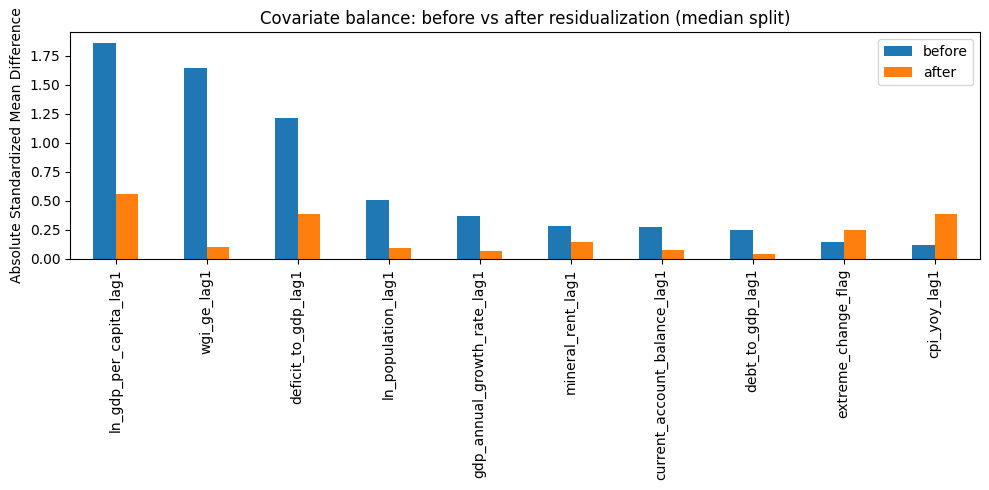

Saved continuous-treatment balance (abs standardized correlations) to: artifacts/balance/continuous_balance_abs_corr.csv


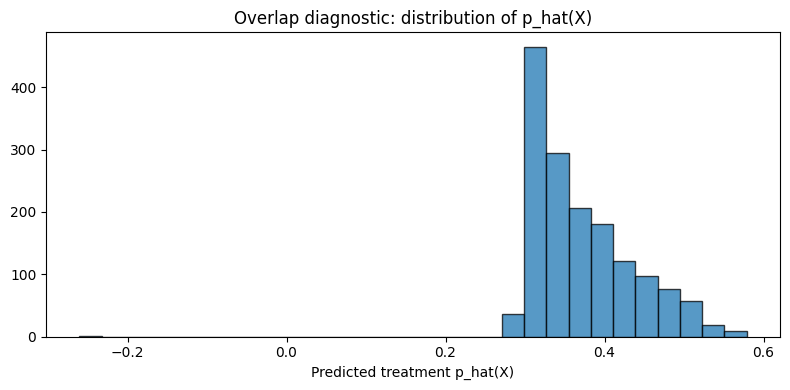


Top 10 SMDs BEFORE:
 ln_gdp_per_capita_lag1          1.858367
wgi_ge_lag1                     1.647938
deficit_to_gdp_lag1             1.215499
ln_population_lag1              0.503227
gdp_annual_growth_rate_lag1     0.371768
mineral_rent_lag1               0.282746
current_account_balance_lag1    0.269144
debt_to_gdp_lag1                0.250124
extreme_change_flag             0.144058
cpi_yoy_lag1                    0.117991
dtype: float64

Top 10 SMDs AFTER:
 ln_gdp_per_capita_lag1          0.555769
cpi_yoy_lag1                    0.386014
deficit_to_gdp_lag1             0.384852
ln_gross_gdp_lag1               0.252441
extreme_change_flag             0.244303
mineral_rent_lag1               0.140153
wgi_ge_lag1                     0.103095
ln_population_lag1              0.087622
current_account_balance_lag1    0.076316
gdp_annual_growth_rate_lag1     0.063139
dtype: float64

Largest 10 abs standardized correlations (continuous-treatment view):
 cpi_yoy_lag1                    0.0

In [27]:
# ===== Balance diagnostics for continuous treatment =====
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --- user inputs (edit if needed) ---
idcol = 'iso3c'
timecol = 'year'
T_col = 'vulnerability_lag1'    # your continuous treatment
covariates = covariates_core  # list of covariate names you want to check
out_dir = "artifacts/balance"
import os; os.makedirs(out_dir, exist_ok=True)

# 0) Merge cross-fitted p_hat (predicted T|X) back into df
#    If your run_dml_loyo returns df_out with p_hat_oos indexed as original df index:
df_bal = df.copy()
df_out = out.get('df_out', None)   # adapt this key if needed
if df_out is None or ('p_hat_oos' not in df_out.columns):
    raise ValueError("No df_out['p_hat_oos'] found. Re-run run_dml_loyo with df_out returning p_hat_oos.")
# left-join by index (requires both share the same index)
df_bal = df_bal.join(df_out[['p_hat_oos']], how='left')

# keep rows that have T, p_hat and covariates observed (or can be coerced numeric)
cols_needed = [T_col, 'p_hat_oos'] + [c for c in covariates if c in df_bal.columns]
df_bal = df_bal[cols_needed].copy()
for c in cols_needed:
    df_bal[c] = pd.to_numeric(df_bal[c], errors='coerce')
df_bal = df_bal.dropna(subset=[T_col, 'p_hat_oos']).copy()

# Helper: compute SMD for a set of covariates given a binary indicator
def compute_smd(df_in, treat_indicator, covs):
    treated = df_in[treat_indicator == 1]
    control = df_in[treat_indicator == 0]
    smd = {}
    for c in covs:
        if c not in df_in.columns: 
            continue
        x_t = pd.to_numeric(treated[c], errors='coerce')
        x_c = pd.to_numeric(control[c], errors='coerce')
        # pooled SD
        sd_pooled = np.sqrt(np.nanvar(x_t, ddof=1) + np.nanvar(x_c, ddof=1)) / np.sqrt(2.0)
        if sd_pooled == 0 or np.isnan(sd_pooled):
            smd[c] = np.nan
        else:
            smd[c] = np.abs(np.nanmean(x_t) - np.nanmean(x_c)) / sd_pooled
    return pd.Series(smd).sort_values(ascending=False)

# 1) Binary split SMDs (median split by T)
df_smd = df_bal.dropna(subset=[T_col]).copy()
df_smd['treated_med'] = (df_smd[T_col] >= df_smd[T_col].median()).astype(int)

# 1a. SMD before
smd_before = compute_smd(df_smd, df_smd['treated_med'], covariates)

# 1b. SMD after residualizing covariates on p_hat (and a quadratic in p_hat)
df_res = df_smd.copy()
# regress each covariate on [1, p_hat, p_hat^2], take residuals
for c in covariates:
    if c not in df_res.columns: 
        continue
    X = df_res[['p_hat_oos']].copy()
    X['p2'] = X['p_hat_oos']**2
    X = sm.add_constant(X)
    y = pd.to_numeric(df_res[c], errors='coerce')
    try:
        fit = sm.OLS(y, X, missing='drop').fit()
        df_res[c + '_res'] = y - fit.predict(X)
    except Exception:
        df_res[c + '_res'] = np.nan

cov_res_cols = [c + '_res' for c in covariates if (c + '_res') in df_res.columns]
smd_after = compute_smd(df_res.dropna(subset=cov_res_cols), df_res.dropna(subset=cov_res_cols)['treated_med'], cov_res_cols)
smd_after.index = [idx.replace('_res','') for idx in smd_after.index]

# Align the two SMD series
smd_tbl = pd.concat([smd_before.rename('before'), smd_after.rename('after')], axis=1)
smd_tbl.to_csv(f"{out_dir}/smd_before_after_median.csv")
print("Saved SMD (median split) to:", f"{out_dir}/smd_before_after_median.csv")

# Plot top-10 SMDs
top = smd_tbl.abs().sort_values('before', ascending=False).head(10)
ax = top.plot(kind='bar', figsize=(10,5))
ax.set_ylabel('Absolute Standardized Mean Difference')
ax.set_title('Covariate balance: before vs after residualization (median split)')
plt.tight_layout()
plt.savefig(f"{out_dir}/smd_bar_top10.png", dpi=150)
plt.show()

# 2) Continuous-treatment balance: |Corr(X_res, T_res)|
# Residualize T and X on [1, p_hat, p_hat^2] (same controls); then report standardized correlations.
X_poly = df_bal[['p_hat_oos']].copy()
X_poly['p2'] = X_poly['p_hat_oos']**2
X_poly = sm.add_constant(X_poly)
# T residual
t_fit = sm.OLS(df_bal[T_col].values, X_poly.values, missing='drop').fit()
T_res = df_bal[T_col] - t_fit.predict(X_poly)
# X residuals + correlations
corrs = {}
for c in covariates:
    if c not in df_bal.columns:
        continue
    try:
        fit_x = sm.OLS(df_bal[c].values, X_poly.values, missing='drop').fit()
        X_res = df_bal[c] - fit_x.predict(X_poly)
        # standardized corr
        num = np.nanmean( (X_res - np.nanmean(X_res)) * (T_res - np.nanmean(T_res)) )
        den = np.nanstd(X_res, ddof=1) * np.nanstd(T_res, ddof=1)
        cor = np.abs(num / den) if (den not in [0, np.nan]) else np.nan
        corrs[c] = cor
    except Exception:
        corrs[c] = np.nan

corr_tbl = pd.Series(corrs, name='|corr( X_res , T_res )|').sort_values(ascending=False)
corr_tbl.to_csv(f"{out_dir}/continuous_balance_abs_corr.csv")
print("Saved continuous-treatment balance (abs standardized correlations) to:", f"{out_dir}/continuous_balance_abs_corr.csv")

# 3) Overlap visual: histogram of p_hat
plt.figure(figsize=(8,4))
plt.hist(df_bal['p_hat_oos'].dropna().values, bins=30, edgecolor='k', alpha=0.75)
plt.xlabel('Predicted treatment p_hat(X)')
plt.title('Overlap diagnostic: distribution of p_hat(X)')
plt.tight_layout()
plt.savefig(f"{out_dir}/p_hat_hist.png", dpi=150)
plt.show()

# 4) Quick summary printouts
print("\nTop 10 SMDs BEFORE:\n", smd_before.head(10))
print("\nTop 10 SMDs AFTER:\n", smd_after.head(10))
print("\nLargest 10 abs standardized correlations (continuous-treatment view):\n", corr_tbl.head(10))

In [29]:
# --- Continuous treatment balance diagnostic (after DML residualization) ---

# Residualize T and X wrt other X (orthogonalization)
X = df_smd[covariates].dropna()
T = df_smd.loc[X.index, T_col]

# regress T on X and take residual
import statsmodels.api as sm
t_model = sm.OLS(T, sm.add_constant(X)).fit()
T_resid = T - t_model.predict(sm.add_constant(X))

# regress each X on remaining X and take residual
X_resid = pd.DataFrame(index=X.index)
for c in covariates:
    others = [o for o in covariates if o != c]
    if not others:
        continue
    mod = sm.OLS(X[c], sm.add_constant(X[others])).fit()
    X_resid[c] = X[c] - mod.predict(sm.add_constant(X[others]))

# correlations |corr(X_resid, T_resid)|
abs_corr = X_resid.apply(lambda col: np.corrcoef(col, T_resid)[0,1])
abs_corr = abs_corr.abs().sort_values(ascending=False)

In [30]:
# Make a compact balance summary table
summ = {}
summ['SMD_before_mean'] = smd_before.abs().mean()
summ['SMD_before_max']  = smd_before.abs().max()
summ['SMD_after_mean']  = smd_after.abs().mean()
summ['SMD_after_max']   = smd_after.abs().max()

# Using your continuous-treatment balances 'abs_corr' from the code I gave
summ['abs_corr_mean'] = abs_corr.mean()
summ['abs_corr_max']  = abs_corr.max()

pd.Series(summ).round(3)

SMD_before_mean    0.607
SMD_before_max     1.858
SMD_after_mean     0.212
SMD_after_max      0.556
abs_corr_mean      0.000
abs_corr_max       0.000
dtype: float64

In [34]:
# ===================== CLEAN DML (LOYO) =====================
import os, time
import numpy as np
import pandas as pd
import statsmodels.api as sm

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LogisticRegressionCV, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ---------- 0) CONFIG ----------
IDCOL   = 'iso3c'
TIMECOL = 'year'
Y_COL   = 'sovereign_spread'
T_RAW   = 'vulnerability'           # original (0..1) vulnerability
T_LAG   = 'vulnerability_lag1'      # we'll create this below
RANDOM_SEED = 2025
N_TREES = 300
MIN_TRAIN_ROWS = 20
USE_KNN = True

out_dir = "artifacts/dml_final"
os.makedirs(out_dir, exist_ok=True)

# ---------- 1) PREPARE DATA (lags, z-score) ----------
# Expect df to exist. If not, load your dataset first.
assert {'iso3c','year',Y_COL,T_RAW}.issubset(df.columns), "df missing required columns."

# Create lag of treatment and key controls if not already present
df = df.copy()
df[T_LAG] = df.groupby(IDCOL)[T_RAW].shift(1)

# Example control lags (only if present)
for c in ['ln_gdp_per_capita','gdp_annual_growth_rate','debt_to_gdp','deficit_to_gdp',
          'current_account_balance','cpi_yoy','wgi_ge','wgi_rl','wgi_cc','wgi_pv','wgi_rq','wgi_va',
          'ln_population','ln_gross_gdp','mineral_rent']:
    if c in df.columns:
        df[f"{c}_lag1"] = df.groupby(IDCOL)[c].shift(1)

# Z-score of lagged treatment for scale-robustness (optional)
if T_LAG in df.columns:
    mu, sd = df[T_LAG].mean(), df[T_LAG].std()
    df['vulnerability_lag1_z'] = (df[T_LAG]-mu)/sd

# Choose treatment to use
T_COL = 'vulnerability_lag1'  # or 'vulnerability_lag1_z' if you prefer standardized effect

# ---------- 2) CHOOSE COVARIATES ----------
covariates_core = [c for c in [
    'ln_gdp_per_capita_lag1','gdp_annual_growth_rate_lag1','debt_to_gdp_lag1',
    'deficit_to_gdp_lag1','current_account_balance_lag1','cpi_yoy_lag1',
    'wgi_ge_lag1','wgi_rl_lag1','wgi_cc_lag1','wgi_pv_lag1','wgi_rq_lag1','wgi_va_lag1',
    'ln_population_lag1','ln_gross_gdp_lag1','mineral_rent_lag1',
    'extreme_change_flag'  # if you created it
] if c in df.columns]

# ---------- 3) PER-FOLD HELPER (no leakage) ----------
def fold_predict_nuisances(df_local, covariates, train_mask, test_mask,
                           ycol, tcol, random_seed=2025, n_trees=300, use_knn=True):
    """
    Fit p(X) and m(X) on TRAIN, predict on TEST. Keeps original indices.
    Returns p_hat_test, m_hat_test (Series aligned to test indices).
    """
    train = df_local.loc[train_mask].copy()
    test  = df_local.loc[test_mask].copy()
    if train.empty or test.empty:
        raise ValueError("Empty train or test slice.")

    covs = [c for c in covariates if c in df_local.columns]
    Xtr = train[covs].apply(pd.to_numeric, errors='coerce')
    Xte = test[covs].apply(pd.to_numeric, errors='coerce')
    ytr = pd.to_numeric(train[ycol], errors='coerce')
    yte = pd.to_numeric(test[ycol], errors='coerce')
    ttr = pd.to_numeric(train[tcol], errors='coerce')
    tte = pd.to_numeric(test[tcol], errors='coerce')

    # Impute on TRAIN only
    try:
        imp = KNNImputer(n_neighbors=5) if use_knn else SimpleImputer(strategy='median')
        Xtr_imp = pd.DataFrame(imp.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
        Xte_imp = pd.DataFrame(imp.transform(Xte), columns=Xte.columns, index=Xte.index)
    except Exception:
        Xtr_imp = Xtr.fillna(Xtr.median(numeric_only=True))
        Xte_imp = Xte.fillna(Xtr.median(numeric_only=True))

    # Scale on TRAIN only
    try:
        sc = StandardScaler()
        Xtr_s = pd.DataFrame(sc.fit_transform(Xtr_imp), columns=Xtr_imp.columns, index=Xtr_imp.index)
        Xte_s = pd.DataFrame(sc.transform(Xte_imp), columns=Xte_imp.columns, index=Xte_imp.index)
    except Exception:
        Xtr_s = Xtr_imp.copy(); Xte_s = Xte_imp.copy()

    # Add year dummies (aligned)
    if TIMECOL in df_local.columns:
        yrs_tr = pd.get_dummies(train[TIMECOL], prefix='yr')
        yrs_te = pd.get_dummies(test[TIMECOL], prefix='yr').reindex(columns=yrs_tr.columns, fill_value=0)
        Xtrain_full = pd.concat([Xtr_s, yrs_tr], axis=1); Xtrain_full.index = Xtr_s.index
        Xtest_full  = pd.concat([Xte_s, yrs_te], axis=1); Xtest_full.index  = Xte_s.index
        Xtest_full  = Xtest_full.reindex(columns=Xtrain_full.columns, fill_value=0)
    else:
        Xtrain_full = Xtr_s; Xtest_full = Xte_s

    # Detect binary treatment
    t_clean = ttr.dropna()
    unique_vals = np.unique(t_clean.values) if t_clean.size>0 else np.array([])
    is_binary = (unique_vals.size == 2) and set(unique_vals).issubset({0,1})

    # Fit p-model
    try:
        if is_binary:
            p_model = LogisticRegressionCV(cv=5, random_state=random_seed, max_iter=5000, solver='lbfgs')\
                        .fit(Xtrain_full.loc[t_clean.index], t_clean)
            p_hat = pd.Series(p_model.predict_proba(Xtest_full)[:,1], index=Xtest_full.index)
        else:
            p_model = LassoCV(cv=5, random_state=random_seed).fit(Xtrain_full.loc[t_clean.index], t_clean)
            p_hat = pd.Series(p_model.predict(Xtest_full), index=Xtest_full.index)
    except Exception:
        p_model = Lasso(max_iter=20000).fit(Xtrain_full.loc[t_clean.index], t_clean)
        p_hat = pd.Series(p_model.predict(Xtest_full), index=Xtest_full.index)

    # Fit m-model (RandomForest; fallback OLS)
    y_clean = ytr.dropna()
    try:
        m_model = RandomForestRegressor(n_estimators=n_trees, random_state=random_seed, n_jobs=-1)\
                    .fit(Xtrain_full.loc[y_clean.index], y_clean)
        m_hat = pd.Series(m_model.predict(Xtest_full), index=Xtest_full.index)
    except Exception:
        m_ols = sm.OLS(y_clean.values, sm.add_constant(Xtrain_full.loc[y_clean.index])).fit()
        m_hat = pd.Series(m_ols.predict(sm.add_constant(Xtest_full)), index=Xtest_full.index)

    return p_hat, m_hat

# ---------- 4) LOYO DML ----------
def run_dml_loyo(df_local, covariates, idcol=IDCOL, timecol=TIMECOL,
                 ycol=Y_COL, tcol=T_COL, n_trees=N_TREES, random_seed=RANDOM_SEED,
                 min_train_rows=MIN_TRAIN_ROWS, use_knn=USE_KNN, verbose=True):
    np.random.seed(random_seed)
    years = sorted(df_local[timecol].dropna().unique())

    u_list, v_list, g_list = [], [], []
    diag, p_r2_folds, m_r2_folds = [], [], []

    # containers for OOS predictions (same index as df_local)
    p_hat_oos = pd.Series(index=df_local.index, dtype=float)
    m_hat_oos = pd.Series(index=df_local.index, dtype=float)

    def oos_r2(y_true, y_pred):
        ss_res = np.nansum((y_true - y_pred)**2)
        ss_tot = np.nansum((y_true - np.nanmean(y_true))**2)
        return np.nan if ss_tot==0 else 1.0 - ss_res/ss_tot

    t0 = time.time()
    folds_used = 0

    for fnum, yr in enumerate(years):
        train_mask = df_local[timecol] != yr
        test_mask  = df_local[timecol] == yr

        # require min train rows w/ y & t
        train_ok = train_mask & (~df_local[ycol].isna()) & (~df_local[tcol].isna())
        if train_ok.sum() < min_train_rows:
            if verbose: print(f"Fold {fnum} {yr}: too few train rows ({train_ok.sum()}) -> skip")
            continue

        try:
            p_hat, m_hat = fold_predict_nuisances(
                df_local, covariates, train_mask, test_mask,
                ycol=ycol, tcol=tcol, random_seed=random_seed,
                n_trees=n_trees, use_knn=use_knn
            )
        except Exception as e:
            if verbose: print(f"Fold {fnum} {yr}: helper failed ({e}) -> skip")
            continue

        # where we have both predictions in test
        idx = p_hat.index.intersection(m_hat.index)
        y_te = pd.to_numeric(df_local.loc[idx, ycol], errors='coerce')
        t_te = pd.to_numeric(df_local.loc[idx, tcol], errors='coerce')
        valid = (~y_te.isna()) & (~t_te.isna())

        idx_valid = idx[valid]
        if idx_valid.size == 0:
            if verbose: print(f"Fold {fnum} {yr}: no valid test rows -> skip")
            continue

        # store OOS predictions on the master containers
        p_hat_oos.loc[idx_valid] = p_hat.loc[idx_valid].values
        m_hat_oos.loc[idx_valid] = m_hat.loc[idx_valid].values

        # residuals for DML moment
        v = t_te.loc[idx_valid].values - p_hat.loc[idx_valid].values
        u = y_te.loc[idx_valid].values - m_hat.loc[idx_valid].values

        # OOS R2
        p_r2_folds.append(oos_r2(t_te.loc[idx_valid].values, p_hat.loc[idx_valid].values))
        m_r2_folds.append(oos_r2(y_te.loc[idx_valid].values, m_hat.loc[idx_valid].values))

        # synthetic unique indices per fold for stacking (not strictly necessary, but tidy)
        base = fnum * 10**6
        new_idx = [base + i for i in range(len(u))]
        u_list.append(pd.Series(u, index=new_idx))
        v_list.append(pd.Series(v, index=new_idx))
        g_list.append(pd.Series(df_local.loc[idx_valid, idcol].values, index=new_idx))

        diag.append({
            'fold': fnum, 'year_holdout': int(yr),
            'n_train': int(train_mask.sum()), 'n_test': int(test_mask.sum()),
            'n_kept': int(len(u)), 'p_oos_r2': float(p_r2_folds[-1]), 'm_oos_r2': float(m_r2_folds[-1])
        })
        folds_used += 1
        if verbose and (fnum % 5 == 0):
            print(f"Processed fold {fnum} (holdout {yr}): kept {len(u)} rows")

    if len(u_list) == 0:
        if verbose: print("No usable folds. Returning NaNs.")
        return {'theta': np.nan, 'res': None, 'diag': pd.DataFrame(diag),
                'p_oos_r2_folds': p_r2_folds, 'm_oos_r2_folds': m_r2_folds,
                'df_out': df_local}

    u_all = pd.concat(u_list).sort_index()
    v_all = pd.concat(v_list).sort_index()
    groups = pd.concat(g_list).sort_index()

    theta = (v_all * u_all).sum() / (v_all**2).sum()
    # Clustered inference by country
    res = sm.OLS(u_all.values, v_all.values).fit(cov_type='cluster', cov_kwds={'groups': groups.values})

    elapsed = time.time() - t0
    if verbose:
        print(f"LOYO DML done in {elapsed:.1f}s; theta={theta:.6g}; stacked rows={len(u_all)}; folds used={folds_used}")

    # attach OOS predictions to df for balance plots
    df_out = df_local.copy()
    df_out['p_hat_oos'] = p_hat_oos
    df_out['m_hat_oos'] = m_hat_oos

    return {
        'theta': float(theta),
        'res': res,
        'diag': pd.DataFrame(diag),
        'p_oos_r2_folds': p_r2_folds,
        'm_oos_r2_folds': m_r2_folds,
        'df_out': df_out
    }

# ---------- 5) RUN POOLED DML ----------
df_run = df.dropna(subset=[Y_COL, T_COL]).copy()
covs_present = [c for c in covariates_core if c in df_run.columns]
print("Using", len(covs_present), "covariates.")
out = run_dml_loyo(df_run, covs_present, ycol=Y_COL, tcol=T_COL,
                   n_trees=N_TREES, random_seed=RANDOM_SEED, min_train_rows=MIN_TRAIN_ROWS, use_knn=USE_KNN, verbose=True)

theta = out['theta']
se    = float(out['res'].bse[0]) if out['res'] is not None else np.nan
pval  = float(out['res'].pvalues[0]) if out['res'] is not None else np.nan
print(f"\nDML RESULT: theta={theta:.6f}, SE={se:.6f}, p={pval:.6f}")
print("Median OOS R2: p(X) =", np.nanmedian(out['p_oos_r2_folds']), " m(X) =", np.nanmedian(out['m_oos_r2_folds']))

# Save diagnostics + predictions for balance
out['diag'].to_csv(os.path.join(out_dir, "dml_fold_diag.csv"), index=False)
summary = pd.DataFrame([{'theta':theta, 'se':se, 'pval':pval,
                         'p_oos_r2_med':np.nanmedian(out['p_oos_r2_folds']),
                         'm_oos_r2_med':np.nanmedian(out['m_oos_r2_folds']),
                         'n_rows': int(df_run.shape[0])}])
summary.to_csv(os.path.join(out_dir, "dml_summary.csv"), index=False)

df = out['df_out']  # keep p_hat_oos, m_hat_oos in your working df for balance diagnostics
print("Saved results to:", out_dir)

Using 16 covariates.
Processed fold 0 (holdout 1997): kept 32 rows
Processed fold 5 (holdout 2002): kept 42 rows
Processed fold 10 (holdout 2007): kept 47 rows
Processed fold 15 (holdout 2012): kept 58 rows
Processed fold 20 (holdout 2017): kept 64 rows
Processed fold 25 (holdout 2022): kept 66 rows
LOYO DML done in 21.5s; theta=-26.6698; stacked rows=1499; folds used=28

DML RESULT: theta=-26.669829, SE=16.122344, p=0.098084
Median OOS R2: p(X) = 0.8120303161213684  m(X) = 0.8290228440065358
Saved results to: artifacts/dml_final


In [35]:
# ================= DML with fold-wise PCA + log(1+spread) variant =================
import numpy as np, pandas as pd, statsmodels.api as sm, time, warnings
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ----------------------- CONFIG -----------------------
IDCOL   = 'iso3c'
YEARCOL = 'year'
Y_COL   = 'sovereign_spread'       # original outcome
T_COL   = 'vulnerability_lag1'     # treatment (lagged)
RANDOM_SEED = 2025
N_TREES     = 200
MIN_TRAIN_ROWS = 10
USE_KNN = True                     # KNN imputation; set False to use median impute

# Define PCA blocks (only vars that exist will be used)
gdp_vars   = [c for c in ['ln_gdp_per_capita_lag1','gdp_annual_growth_rate_lag1'] if c in df.columns]
debt_vars  = [c for c in ['debt_to_gdp_lag1','deficit_to_gdp_lag1','current_account_balance_lag1'] if c in df.columns]
wgi_vars   = [c for c in ['wgi_ge_lag1','wgi_rl_lag1','wgi_cc_lag1','wgi_pv_lag1','wgi_rq_lag1','wgi_va_lag1'] if c in df.columns]

# Build ONE combined block to compress (you can split into multiple if you prefer)
dev_block = gdp_vars + debt_vars + wgi_vars

# Any extra single covariates (kept as-is; will be imputed/scaled per fold)
extra_covs = [c for c in ['extreme_change_flag'] if c in df.columns]

# PCA selection rule
PCA_VAR_THRESH = 0.85   # explain at least 85% of variance
PCA_MAX_COMPS  = 3      # cap on number of PCs from the block

# ---------------- fold-wise PCA helper ----------------
def foldwise_build_design(train_df, test_df, dev_cols, extra_cols,
                          use_knn=True, random_seed=RANDOM_SEED):
    """
    Returns (Xtrain, Xtest) with:
      - dev_cols replaced by 1..K PCs chosen on train (85% var up to 3 PCs),
      - extra_cols included as they are.
    Imputation & scaling are fit on TRAIN only for both PC block and extra covs.
    """
    rng = np.random.RandomState(random_seed)

    # 1) Handle the dev (PCA) block
    dev_cols = [c for c in dev_cols if c in train_df.columns]
    Xtr_dev = train_df[dev_cols].apply(pd.to_numeric, errors='coerce') if dev_cols else pd.DataFrame(index=train_df.index)
    Xte_dev = test_df[dev_cols].apply(pd.to_numeric, errors='coerce')  if dev_cols else pd.DataFrame(index=test_df.index)

    # impute dev block
    if dev_cols:
        if use_knn:
            imp_dev = KNNImputer(n_neighbors=5)
        else:
            imp_dev = SimpleImputer(strategy='median')
        Xtr_dev_imp = pd.DataFrame(imp_dev.fit_transform(Xtr_dev), columns=dev_cols, index=train_df.index)
        Xte_dev_imp = pd.DataFrame(imp_dev.transform(Xte_dev),   columns=dev_cols, index=test_df.index)
        # scale dev block
        sc_dev = StandardScaler().fit(Xtr_dev_imp)
        Xtr_dev_s = pd.DataFrame(sc_dev.transform(Xtr_dev_imp), columns=dev_cols, index=train_df.index)
        Xte_dev_s = pd.DataFrame(sc_dev.transform(Xte_dev_imp), columns=dev_cols, index=test_df.index)
        # choose K via train explained var
        if Xtr_dev_s.shape[1] == 1:
            n_comp = 1
            pca_dev = PCA(n_components=1).fit(Xtr_dev_s.values)
        else:
            pca_full = PCA(n_components=min(PCA_MAX_COMPS, Xtr_dev_s.shape[1])).fit(Xtr_dev_s.values)
            cumvar = np.cumsum(pca_full.explained_variance_ratio_)
            n_comp = int(np.searchsorted(cumvar, PCA_VAR_THRESH) + 1)
            n_comp = max(1, min(PCA_MAX_COMPS, n_comp))
            pca_dev = PCA(n_components=n_comp).fit(Xtr_dev_s.values)
        # transform
        Ztr = pca_dev.transform(Xtr_dev_s.values)
        Zte = pca_dev.transform(Xte_dev_s.values)
        pc_cols = [f'dev_pc{i+1}' for i in range(n_comp)]
        Xtr_pc = pd.DataFrame(Ztr, index=train_df.index, columns=pc_cols)
        Xte_pc = pd.DataFrame(Zte, index=test_df.index,  columns=pc_cols)
    else:
        Xtr_pc = pd.DataFrame(index=train_df.index)
        Xte_pc = pd.DataFrame(index=test_df.index)

    # 2) Handle extra_cols (non-PCA covs)
    extra_cols = [c for c in extra_cols if c in train_df.columns]
    if extra_cols:
        Xtr_ex = train_df[extra_cols].apply(pd.to_numeric, errors='coerce')
        Xte_ex = test_df[extra_cols].apply(pd.to_numeric, errors='coerce')
        if use_knn:
            imp_ex = KNNImputer(n_neighbors=5)
        else:
            imp_ex = SimpleImputer(strategy='median')
        Xtr_ex_imp = pd.DataFrame(imp_ex.fit_transform(Xtr_ex), columns=extra_cols, index=train_df.index)
        Xte_ex_imp = pd.DataFrame(imp_ex.transform(Xte_ex),     columns=extra_cols, index=test_df.index)
        sc_ex = StandardScaler().fit(Xtr_ex_imp)
        Xtr_ex_s = pd.DataFrame(sc_ex.transform(Xtr_ex_imp), columns=extra_cols, index=train_df.index)
        Xte_ex_s = pd.DataFrame(sc_ex.transform(Xte_ex_imp), columns=extra_cols, index=test_df.index)
    else:
        Xtr_ex_s = pd.DataFrame(index=train_df.index)
        Xte_ex_s = pd.DataFrame(index=test_df.index)

    # 3) Combine PCs + extras, then add aligned year dummies
    Xtr = pd.concat([Xtr_pc, Xtr_ex_s], axis=1)
    Xte = pd.concat([Xte_pc, Xte_ex_s], axis=1)

    yrs_tr = pd.get_dummies(train_df[YEARCOL], prefix='yr')
    yrs_te = pd.get_dummies(test_df[YEARCOL],  prefix='yr').reindex(columns=yrs_tr.columns, fill_value=0)
    Xtr = pd.concat([Xtr, yrs_tr], axis=1)
    Xte = pd.concat([Xte, yrs_te], axis=1)
    Xte = Xte.reindex(columns=Xtr.columns, fill_value=0)

    return Xtr, Xte

# ----------------- LOYO DML with fold-wise PCA -----------------
def run_dml_loyo_foldpca(df_local, ycol=Y_COL, tcol=T_COL,
                         dev_cols=dev_block, extra_cols=extra_covs,
                         n_trees=N_TREES, random_seed=RANDOM_SEED,
                         min_train_rows=MIN_TRAIN_ROWS, use_knn=USE_KNN, verbose=True):
    np.random.seed(random_seed)

    # keep rows with required columns
    df_use = df_local.copy()
    years = sorted(df_use[YEARCOL].dropna().unique())

    u_list = []; v_list = []; groups_list = []; diag = []
    p_oos_r2_folds = []; m_oos_r2_folds = []
    t0 = time.time(); folds_used = 0

    def safe_oos_r2(y_true, y_pred):
        ss_res = np.nansum((y_true - y_pred)**2)
        ss_tot = np.nansum((y_true - np.nanmean(y_true))**2)
        if ss_tot == 0: return np.nan
        return 1.0 - ss_res / ss_tot

    for fnum, hold in enumerate(years):
        train = df_use[df_use[YEARCOL] != hold]
        test  = df_use[df_use[YEARCOL] == hold]

        # y,t
        ytr = pd.to_numeric(train[ycol], errors='coerce')
        yte = pd.to_numeric(test[ycol],  errors='coerce')
        ttr = pd.to_numeric(train[tcol], errors='coerce')
        tte = pd.to_numeric(test[tcol],  errors='coerce')

        # need minimum train rows with both y and t
        train_mask = (~ytr.isna()) & (~ttr.isna())
        if train_mask.sum() < min_train_rows:
            if verbose: print(f"Fold {fnum} (holdout {hold}): too few train rows, skip")
            continue

        # Build design with fold-wise PCA
        try:
            Xtr, Xte = foldwise_build_design(train, test, dev_cols, extra_cols, use_knn=use_knn, random_seed=random_seed)
        except Exception as e:
            if verbose: print(f"Fold {fnum} (holdout {hold}): PCA build failed: {e}")
            continue

        # Restrict Xtr to rows where y & t exist (t-model uses ttr non-missing; y-model uses ytr non-missing)
        Xtr_t = Xtr.loc[train_mask.index][train_mask.values]
        ttr_  = ttr.loc[train_mask.index][train_mask.values].astype(float)

        # fit p(X|train)
        try:
            uniq = np.unique(ttr_.dropna().values)
            is_bin = (len(uniq)==2) and set(uniq).issubset({0,1})
            if is_bin:
                p_model = LogisticRegressionCV(cv=5, random_state=random_seed, max_iter=5000, solver='lbfgs').fit(Xtr_t, ttr_)
                p_hat = p_model.predict_proba(Xte)[:,1]
            else:
                p_model = LassoCV(cv=5, random_state=random_seed).fit(Xtr_t, ttr_)
                p_hat = p_model.predict(Xte)
        except Exception:
            from sklearn.linear_model import Lasso
            p_model = Lasso(max_iter=20000).fit(Xtr_t, ttr_)
            p_hat = p_model.predict(Xte)

        # m(X): train where y non-missing
        ymask = (~ytr.isna())
        Xtr_y = Xtr.loc[ymask.index][ymask.values]
        ytr_  = ytr.loc[ymask.index][ymask.values].astype(float)
        try:
            m_model = RandomForestRegressor(n_estimators=n_trees, random_state=random_seed, n_jobs=-1).fit(Xtr_y, ytr_)
            m_hat = m_model.predict(Xte)
        except Exception:
            m_ols = sm.OLS(ytr_, sm.add_constant(Xtr_y)).fit()
            m_hat = m_ols.predict(sm.add_constant(Xte))

        # test residuals where y & t present
        test_mask = (~yte.isna()) & (~tte.isna())
        if test_mask.sum() == 0:
            if verbose: print(f"Fold {fnum} (holdout {hold}): no test rows with y&t, skip")
            continue

        t_true = tte[test_mask].to_numpy().astype(float)
        y_true = yte[test_mask].to_numpy().astype(float)

        # OOS R2
        p_r2 = safe_oos_r2(t_true, p_hat[test_mask.values])
        m_r2 = safe_oos_r2(y_true, m_hat[test_mask.values])
        p_oos_r2_folds.append(p_r2); m_oos_r2_folds.append(m_r2)

        v_hat = t_true - p_hat[test_mask.values]
        u_hat = y_true - m_hat[test_mask.values]

        base = fnum * 10**6
        idxs = [base+i for i in range(len(u_hat))]
        u_list.append(pd.Series(u_hat, index=idxs))
        v_list.append(pd.Series(v_hat, index=idxs))
        groups_list.append(pd.Series(test.loc[test_mask, IDCOL].values, index=idxs))

        folds_used += 1
        if verbose and (fnum % 5 == 0):
            print(f"Processed fold {fnum} (holdout {hold}): kept {len(u_hat)} rows")

    if len(u_list) == 0:
        return {'theta': np.nan, 'res': None, 'u_all': None, 'v_all': None, 'groups': None,
                'p_oos_r2_folds': p_oos_r2_folds, 'm_oos_r2_folds': m_oos_r2_folds}

    u_all = pd.concat(u_list).sort_index()
    v_all = pd.concat(v_list).sort_index()
    groups = pd.concat(groups_list).sort_index()

    theta = (v_all * u_all).sum() / (v_all**2).sum()
    try:
        res = sm.OLS(u_all.values, v_all.values).fit(cov_type='cluster', cov_kwds={'groups': groups.values})
    except Exception:
        res = sm.OLS(u_all.values, v_all.values).fit(cov_type='HC1')

    elapsed = time.time() - t0
    if verbose:
        print(f"\nLOYO DML done in {elapsed:.1f}s; theta={theta:.6g}; stacked rows={len(u_all)}; folds used={folds_used}")

    return {'theta': float(theta), 'res': res,
            'u_all': u_all, 'v_all': v_all, 'groups': groups,
            'p_oos_r2_folds': p_oos_r2_folds, 'm_oos_r2_folds': m_oos_r2_folds}

# ----------------- RUN 1: DML with fold-wise PCA (original Y) -----------------
df_run = df.dropna(subset=[T_COL, Y_COL]).copy()
out_pca = run_dml_loyo_foldpca(df_run, ycol=Y_COL, tcol=T_COL,
                               dev_cols=dev_block, extra_cols=extra_covs,
                               n_trees=N_TREES, random_seed=RANDOM_SEED,
                               min_train_rows=MIN_TRAIN_ROWS, use_knn=USE_KNN, verbose=True)

theta = out_pca['theta']
se    = float(out_pca['res'].bse[0]) if out_pca['res'] is not None else np.nan
pval  = float(out_pca['res'].pvalues[0]) if out_pca['res'] is not None else np.nan
p_med = np.nanmedian(out_pca['p_oos_r2_folds']) if out_pca['p_oos_r2_folds'] else np.nan
m_med = np.nanmedian(out_pca['m_oos_r2_folds']) if out_pca['m_oos_r2_folds'] else np.nan

print("\n=== PCA-DML (levels outcome) ===")
print(f"Theta = {theta:.6f}, SE = {se:.6f}, p = {pval:.4f}")
print(f"Median OOS R²: p(X) = {p_med}, m(X) = {m_med}")

# ----------------- RUN 2: DML with fold-wise PCA (log(1+spread)) --------------
df_log = df.copy()
# ensure outcome domain; if spread is never negative/NaN you can relax this guard
df_log = df_log[df_log[Y_COL] > -0.99]
df_log['y_log1p'] = np.log1p(df_log[Y_COL])

df_run_log = df_log.dropna(subset=[T_COL, 'y_log1p']).copy()
out_pca_log = run_dml_loyo_foldpca(df_run_log, ycol='y_log1p', tcol=T_COL,
                                   dev_cols=dev_block, extra_cols=extra_covs,
                                   n_trees=N_TREES, random_seed=RANDOM_SEED,
                                   min_train_rows=MIN_TRAIN_ROWS, use_knn=USE_KNN, verbose=True)

theta_l = out_pca_log['theta']
se_l    = float(out_pca_log['res'].bse[0]) if out_pca_log['res'] is not None else np.nan
pval_l  = float(out_pca_log['res'].pvalues[0]) if out_pca_log['res'] is not None else np.nan
p_med_l = np.nanmedian(out_pca_log['p_oos_r2_folds']) if out_pca_log['p_oos_r2_folds'] else np.nan
m_med_l = np.nanmedian(out_pca_log['m_oos_r2_folds']) if out_pca_log['m_oos_r2_folds'] else np.nan

print("\n=== PCA-DML (log(1+spread) outcome) ===")
print(f"Theta = {theta_l:.6f}, SE = {se_l:.6f}, p = {pval_l:.4f}")
print(f"Median OOS R²: p(X) = {p_med_l}, m(X) = {m_med_l}")

Processed fold 0 (holdout 1997): kept 32 rows
Processed fold 5 (holdout 2002): kept 42 rows
Processed fold 10 (holdout 2007): kept 47 rows
Processed fold 15 (holdout 2012): kept 58 rows
Processed fold 20 (holdout 2017): kept 64 rows
Processed fold 25 (holdout 2022): kept 66 rows

LOYO DML done in 8.5s; theta=-0.362591; stacked rows=1499; folds used=28

=== PCA-DML (levels outcome) ===
Theta = -0.362591, SE = 3.980030, p = 0.9274
Median OOS R²: p(X) = 0.6385771109169206, m(X) = 0.6394898107125919
Processed fold 0 (holdout 1997): kept 30 rows
Processed fold 5 (holdout 2002): kept 39 rows
Processed fold 10 (holdout 2007): kept 44 rows
Processed fold 15 (holdout 2012): kept 57 rows
Processed fold 20 (holdout 2017): kept 45 rows
Processed fold 25 (holdout 2022): kept 53 rows

LOYO DML done in 6.6s; theta=1.01186; stacked rows=1275; folds used=28

=== PCA-DML (log(1+spread) outcome) ===
Theta = 1.011855, SE = 1.129746, p = 0.3704
Median OOS R²: p(X) = 0.6381754904126414, m(X) = 0.48947000612

In [41]:
def run_dml_se_grid(df, covs, idcol, timecol, ycol, tcol, random_seed=2025, alpha_trim=0.02):
    """
    1) Fit baseline LassoCV for p(X) to get alpha grid & SE-rule alphas (no leakage; just to pick alphas).
    2) Re-run LOYO DML with fixed alphas: SE-1, SE-0.5, (opt), SE+0.5, SE+1.
    3) Report on/off support counts using the intersection of central bands across specs.
    """
    import numpy as np, pandas as pd
    from sklearn.impute import KNNImputer
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LassoCV

    # ----- Build X for the alpha-selection fit with PERFECT index alignment -----
    X_raw = df[covs].apply(pd.to_numeric, errors='coerce')
    t_raw = pd.to_numeric(df[tcol], errors='coerce')
    yr_d  = pd.get_dummies(df[timecol], prefix='yr')

    # same index for all parts
    X_full = pd.concat([X_raw, yr_d], axis=1)               # never reset_index
    mask   = ~t_raw.isna()                                  # keep rows where t is observed
    X_sub  = X_full.loc[mask]
    t_sub  = t_raw.loc[mask]

    # impute/scale on the kept rows only (maintain index)
    imputer = KNNImputer(n_neighbors=5)
    X_imp   = pd.DataFrame(imputer.fit_transform(X_sub),
                           columns=X_sub.columns, index=X_sub.index)
    scaler  = StandardScaler()
    X_s     = pd.DataFrame(scaler.fit_transform(X_imp),
                           columns=X_imp.columns, index=X_imp.index)

    # ----- LassoCV to get SE-rule alphas -----
    lcv = LassoCV(cv=5, random_state=random_seed).fit(X_s, t_sub)
    alpha_by_rule = se_rule_alphas(lcv, k_list=(-1.0, -0.5, 0.0, +0.5, +1.0))

    # ----- Run DML for each alpha (collect p_hat to compute common support) -----
    rows = []
    phats = {}
    df_run = df.dropna(subset=[tcol, ycol])  # DML sample

    for label, a in alpha_by_rule.items():
        out = dml_with_fixed_palpha(df_run, covs, idcol, timecol, ycol, tcol,
                                    alpha=a, random_seed=random_seed)
        rows.append({
            'spec': label,
            'theta': out['theta'],
            'se': out['se'],
            'pval': out['pval'],
            'alpha': a
        })
        phats[label] = out['p_hat']  # Series indexed by original df indices

    # ----- Common support: intersection of central bands across p_hat columns -----
    if phats:
        lo_list, hi_list = [], []
        for s in phats.values():
            s = s.dropna()
            lo_list.append(s.quantile(alpha_trim))
            hi_list.append(s.quantile(1 - alpha_trim))
        lo, hi = max(lo_list), min(hi_list)

        on_off = {}
        for label, s in phats.items():
            s = s.dropna()
            on  = int(((s >= lo) & (s <= hi)).sum())
            off = int((~((s >= lo) & (s <= hi))).sum())
            on_off[label] = (on, off)
    else:
        lo = hi = np.nan
        on_off = {}

    res = pd.DataFrame(rows)
    res['on_support']  = res['spec'].map(lambda k: on_off.get(k, (np.nan, np.nan))[0])
    res['off_support'] = res['spec'].map(lambda k: on_off.get(k, (np.nan, np.nan))[1])

    # order like the paper
    order_map = {'SE-1.0':0, 'SE-0.5':1, ' (opt)':2, 'SE+0.5':3, 'SE+1.0':4}
    res['order'] = res['spec'].map(order_map).fillna(99)
    res = res.sort_values('order').drop(columns='order').reset_index(drop=True)

    meta = {'alpha_by_rule': alpha_by_rule, 'support_band': (lo, hi)}
    return res, meta

In [39]:
# --- utilities to extract SE-rule alphas from a fitted LassoCV ---
import numpy as np, pandas as pd
from sklearn.linear_model import LassoCV, Lasso
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

def se_rule_alphas(lcv, k_list=(-1.0, -0.5, 0.0, +0.5, +1.0)):
    """
    From a fitted LassoCV(lcv), compute alpha_* for the SE-rule variants:
    k = 0    -> alpha at min CV-MSE
    k = ±0.5 -> within ±0.5 * (std error of min) band
    k = ±1   -> within ±1 * (std error of min) band
    Returns dict: {label: alpha_value}
    """
    # lcv.alphas_ (array, descending), lcv.mse_path_ (n_alphas x n_folds) or (n_folds x n_alphas)
    mse_path = lcv.mse_path_
    # shape guard (sklearn toggled shapes across versions)
    if mse_path.shape[0] != len(lcv.alphas_):
        mse_path = mse_path.T  # make it (n_alphas, n_folds)

    mean_mse = mse_path.mean(axis=1)
    se_mse   = mse_path.std(axis=1, ddof=1) / np.sqrt(mse_path.shape[1])
    amin_idx = int(np.argmin(mean_mse))
    mse_min  = float(mean_mse[amin_idx])
    se_min   = float(se_mse[amin_idx])

    out = {}
    for k in k_list:
        # target mse threshold
        thr = mse_min + max(0.0, k) * se_min
        # For k>=0, choose the *largest* alpha (most regularized) with mean_mse <= thr (SE-rule style)
        # For k<0 (less regularization), choose the *smallest* alpha with mean_mse <= mse_min - |k|*se_min (if any)
        if k >= 0:
            ok = np.where(mean_mse <= thr)[0]
            idx = ok[-1] if len(ok) else amin_idx
        else:
            thr_lo = mse_min - (-k) * se_min
            ok = np.where(mean_mse <= thr_lo)[0]
            idx = ok[0] if len(ok) else amin_idx
        label = "SE{:+.1f}".format(k).replace("+0.0"," (opt)").replace("SE0.0"," (opt)")
        out[label] = float(lcv.alphas_[idx])
    return out

# --- light wrapper that re-runs your DML with a fixed p-alpha and returns θ, SE, p, and p_hat for support ---
def dml_with_fixed_palpha(df, covs, idcol, timecol, ycol, tcol, alpha, random_seed=2025):
    """
    Uses per-fold impute/scale and a fixed Lasso(alpha) for p(X), RF for m(X).
    Re-implements the essentials inline so we can collect p_hat for support.
    """
    import statsmodels.api as sm
    years = sorted(df[timecol].dropna().unique())
    u_list=[]; v_list=[]; g_list=[]; diag=[]; all_phat=[]
    rng = np.random.RandomState(random_seed)

    for fnum, yr in enumerate(years):
        train = df[df[timecol]!=yr]
        test  = df[df[timecol]==yr]
        Xtr = train[covs].apply(pd.to_numeric, errors='coerce')
        Xte = test[covs].apply(pd.to_numeric, errors='coerce')
        ytr = pd.to_numeric(train[ycol], errors='coerce'); yte = pd.to_numeric(test[ycol], errors='coerce')
        ttr = pd.to_numeric(train[tcol], errors='coerce'); tte = pd.to_numeric(test[tcol], errors='coerce')

        # impute+scale on TRAIN
        imputer = KNNImputer(n_neighbors=5)
        Xtr_imp = pd.DataFrame(imputer.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
        Xte_imp = pd.DataFrame(imputer.transform(Xte),   columns=Xte.columns, index=Xte.index)
        sc = StandardScaler()
        Xtr_s = pd.DataFrame(sc.fit_transform(Xtr_imp), columns=Xtr_imp.columns, index=Xtr_imp.index)
        Xte_s = pd.DataFrame(sc.transform(Xte_imp),     columns=Xte_imp.columns, index=Xte_imp.index)

        # add aligned year dummies
        yr_tr = pd.get_dummies(train[timecol], prefix='yr'); yr_te = pd.get_dummies(test[timecol], prefix='yr').reindex(columns=yr_tr.columns, fill_value=0)
        Xtr_f = pd.concat([Xtr_s.reset_index(drop=True), yr_tr.reset_index(drop=True)], axis=1)
        Xte_f = pd.concat([Xte_s.reset_index(drop=True), yr_te.reset_index(drop=True)], axis=1)
        Xte_f = Xte_f.reindex(columns=Xtr_f.columns, fill_value=0)

        mask_tr = (~ytr.isna()) & (~ttr.isna())
        if mask_tr.sum() < 10 or np.nanvar(ttr[mask_tr].values)==0: 
            continue

        # fixed-alpha Lasso for p(X)
        p_mod = Lasso(alpha=alpha, max_iter=20000, random_state=random_seed).fit(Xtr_f[mask_tr], ttr[mask_tr])
        p_hat = p_mod.predict(Xte_f)
        # RF for m(X)
        from sklearn.ensemble import RandomForestRegressor
        m_mod = RandomForestRegressor(n_estimators=200, random_state=random_seed, n_jobs=-1).fit(Xtr_f[mask_tr], ytr[mask_tr])
        m_hat = m_mod.predict(Xte_f)

        mask_te = (~yte.isna()) & (~tte.isna())
        if mask_te.sum()==0: 
            continue
        yv = yte[mask_te].values; tv = tte[mask_te].values
        pv = p_hat[mask_te.values] if isinstance(mask_te.values[0], (np.bool_, bool)) else p_hat[mask_te]
        mv = m_hat[mask_te.values] if isinstance(mask_te.values[0], (np.bool_, bool)) else m_hat[mask_te]

        u = yv - mv; v = tv - pv
        idx = np.arange(len(u)) + fnum*10**6
        u_list.append(pd.Series(u, index=idx)); v_list.append(pd.Series(v, index=idx))
        g_list.append(pd.Series(test.loc[mask_te, idcol].values, index=idx))
        # keep p_hat for support calc
        all_phat.append(pd.Series(p_hat, index=test.index))

    if not u_list:
        return {'theta':np.nan,'se':np.nan,'pval':np.nan,'p_hat':pd.Series(dtype=float),'on_support':np.nan}

    u_all = pd.concat(u_list).sort_index(); v_all = pd.concat(v_list).sort_index(); groups = pd.concat(g_list).sort_index()
    exog = np.asarray(v_all).reshape(-1,1); endog = np.asarray(u_all)
    res = sm.OLS(endog, exog).fit(cov_type='cluster', cov_kwds={'groups': groups.values})
    # collect p_hat
    p_hat_full = pd.concat(all_phat).sort_index()
    return {'theta': float(res.params[0]), 'se': float(res.bse[0]), 'pval': float(res.pvalues[0]),
            'p_hat': p_hat_full}

def run_dml_se_grid(df, covs, idcol, timecol, ycol, tcol, random_seed=2025, alpha_trim=0.02):
    """
    1) Fit a baseline LassoCV for p(X) to get alpha grid & 1SE rule.
    2) Re-run DML with fixed alphas for SE-1, SE-0.5, opt, SE+0.5, SE+1.
    3) Compute 'on/off support' as fraction inside the intersection of central [α,1-α] of p_hat across columns.
    """
    # quick baseline fit to get SE-rule alphas
    # use the whole sample (with impute/scale) to determine the grid ONLY (we still do LOYO in DML)
    X = df[covs].apply(pd.to_numeric, errors='coerce')
    t = pd.to_numeric(df[tcol], errors='coerce')
    imp = KNNImputer(n_neighbors=5); sc = StandardScaler()
    X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)
    X_s   = pd.DataFrame(sc.fit_transform(X_imp), columns=X_imp.columns, index=X_imp.index)
    yr_d  = pd.get_dummies(df[timecol], prefix='yr')
    X_s   = pd.concat([X_s.reset_index(drop=True), yr_d.reset_index(drop=True)], axis=1)
    X_s   = X_s.loc[~t.isna()]
    t_s   = t.loc[X_s.index]

    lcv = LassoCV(cv=5, random_state=random_seed).fit(X_s, t_s)
    alpha_by_rule = se_rule_alphas(lcv, k_list=(-1.0,-0.5,0.0,+0.5,+1.0))  # dict

    # run DML for each alpha
    cols = []
    phats = {}
    for label, a in alpha_by_rule.items():
        out = dml_with_fixed_palpha(df.dropna(subset=[tcol,ycol]), covs, idcol, timecol, ycol, tcol, alpha=a, random_seed=random_seed)
        cols.append({'spec':label, 'theta':out['theta'], 'se':out['se'], 'pval':out['pval'], 'alpha':a})
        phats[label] = out['p_hat']

    # on/off support: intersection of central bands
    # for each column, compute central [α,1-α] for its p_hat; intersect across columns; count inside
    if phats:
        lo_list=[]; hi_list=[]
        for label, s in phats.items():
            s = s.dropna()
            lo_list.append(s.quantile(alpha_trim)); hi_list.append(s.quantile(1-alpha_trim))
        lo = max(lo_list); hi = min(hi_list)
        # compute on-support counts per column (same band for comparability)
        on_off = {}
        for label, s in phats.items():
            s = s.dropna()
            on = int(((s>=lo)&(s<=hi)).sum()); off = int((~((s>=lo)&(s<=hi))).sum())
            on_off[label] = (on, off)
    else:
        on_off = {}

    res = pd.DataFrame(cols)
    res['on_support']  = res['spec'].map(lambda k: on_off.get(k,(np.nan,np.nan))[0])
    res['off_support'] = res['spec'].map(lambda k: on_off.get(k,(np.nan,np.nan))[1])
    # pretty order
    order = ['SE-1.0','SE-0.5',' (opt)','SE+0.5','SE+1.0']
    res['order'] = res['spec'].map({k:i for i,k in enumerate(order)})
    res = res.sort_values('order').drop(columns='order')
    return res, {'alpha_by_rule':alpha_by_rule, 'support_band':(lo,hi) if phats else (np.nan,np.nan)}

In [42]:
# inputs you already have
idcol='iso3c'; timecol='year'
Y_col='sovereign_spread'          # or 'log1p_spread'
T_col='vulnerability_lag1'        # or your binary indicator if you binarize
covs = covariates_core            # your cleaned/lagged covariate list (no treatment/outcome inside)

res_table, meta = run_dml_se_grid(df, covs, idcol, timecol, Y_col, T_col, random_seed=2025, alpha_trim=0.02)
print(res_table)
print("SE-rule alphas:", meta['alpha_by_rule'])
print("Common support band for p_hat:", meta['support_band'])

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

SE- not fixed


In [47]:
def dml_with_fixed_palpha(df, covs, idcol, timecol, ycol, tcol, alpha, random_seed=2025):
    """
    Leave-One-Year-Out DML using a fixed Lasso(alpha) for p(X).
    Index-safe: never uses boolean masks directly as indexers.
    Returns theta, SE, pval, and the cross-fitted p_hat for support counts.
    """
    import numpy as np, pandas as pd, statsmodels.api as sm
    from sklearn.impute import KNNImputer
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import Lasso
    from sklearn.ensemble import RandomForestRegressor

    # Build X (covs + year dummies) aligned to df.index
    X_raw = df[covs].apply(pd.to_numeric, errors='coerce')
    Y = pd.to_numeric(df[ycol], errors='coerce')
    T = pd.to_numeric(df[tcol], errors='coerce')
    yr = pd.get_dummies(df[timecol], prefix='yr')
    X_full0 = pd.concat([X_raw, yr], axis=1)  # index == df.index

    years = sorted(df[timecol].dropna().unique())
    u_parts, v_parts, g_parts = [], [], []
    p_hat_oos = pd.Series(index=df.index, dtype=float)

    for fold, hold in enumerate(years):
        tr_idx = df.index[df[timecol] != hold]
        te_idx = df.index[df[timecol] == hold]

        Xtr0 = X_full0.loc[tr_idx]
        Xte0 = X_full0.loc[te_idx]

        # Impute + scale on TRAIN only
        imputer = KNNImputer(n_neighbors=5)
        Xtr_imp = pd.DataFrame(imputer.fit_transform(Xtr0), columns=Xtr0.columns, index=tr_idx)
        Xte_imp = pd.DataFrame(imputer.transform(Xte0), columns=Xte0.columns, index=te_idx)

        scaler = StandardScaler()
        Xtr = pd.DataFrame(scaler.fit_transform(Xtr_imp), columns=Xtr_imp.columns, index=tr_idx)
        Xte = pd.DataFrame(scaler.transform(Xte_imp), columns=Xte_imp.columns, index=te_idx)

        # Training rows with both Y and T
        tr_mask = (~Y.loc[tr_idx].isna()) & (~T.loc[tr_idx].isna())
        idx_keep = tr_mask[tr_mask].index
        if len(idx_keep) < 10:
            continue

        # p-learner (fixed alpha)
        p_mod = Lasso(alpha=float(alpha), max_iter=20000, random_state=random_seed)
        p_mod.fit(Xtr.loc[idx_keep], T.loc[idx_keep])
        p_hat_fold = pd.Series(p_mod.predict(Xte), index=te_idx)
        p_hat_oos.loc[te_idx] = p_hat_fold

        # m-learner
        y_tr_mask = ~Y.loc[tr_idx].isna()
        idx_y = y_tr_mask[y_tr_mask].index
        try:
            m_mod = RandomForestRegressor(n_estimators=200, random_state=random_seed, n_jobs=-1)
            m_mod.fit(Xtr.loc[idx_y], Y.loc[idx_y])
            m_hat_fold = pd.Series(m_mod.predict(Xte), index=te_idx)
        except Exception:
            m_ols = sm.OLS(Y.loc[idx_y].values, sm.add_constant(Xtr.loc[idx_y])).fit()
            m_hat_fold = pd.Series(m_ols.predict(sm.add_constant(Xte)), index=te_idx)

        # Residuals on test rows with both Y and T
        te_keep = te_idx[(~Y.loc[te_idx].isna()) & (~T.loc[te_idx].isna())]
        if len(te_keep) == 0:
            continue

        v = T.loc[te_keep].values - p_hat_fold.loc[te_keep].values
        u = Y.loc[te_keep].values - m_hat_fold.loc[te_keep].values

        base = fold * 10**6
        idx = [base + i for i in range(len(u))]
        u_parts.append(pd.Series(u, index=idx))
        v_parts.append(pd.Series(v, index=idx))
        g_parts.append(pd.Series(df.loc[te_keep, idcol].values, index=idx))

    if not u_parts:
        return {'theta': np.nan, 'se': np.nan, 'pval': np.nan, 'p_hat': p_hat_oos}

    u_all = pd.concat(u_parts).sort_index()
    v_all = pd.concat(v_parts).sort_index()
    g_all = pd.concat(g_parts).sort_index()

    theta = float((v_all * u_all).sum() / (v_all**2).sum())
    try:
        res = sm.OLS(u_all.values, v_all.values).fit(cov_type='cluster', cov_kwds={'groups': g_all.values})
        se = float(res.bse[0]); pval = float(res.pvalues[0])
    except Exception:
        res = sm.OLS(u_all.values, v_all.values).fit(cov_type='HC1')
        se = float(res.bse[0]); pval = float(res.pvalues[0])

    return {'theta': theta, 'se': se, 'pval': pval, 'p_hat': p_hat_oos}

In [48]:
# ---------- SE-rule grid wrapper (index-safe) ----------
def run_dml_se_grid(df, covs, idcol, timecol, ycol, tcol, random_seed=2025, alpha_trim=0.02):
    """
    1) Get SE-rule alphas from a LassoCV on p(X) using aligned indices.
    2) Run fixed-α LOYO DML for SE−1, SE−0.5, Opt, SE+0.5, SE+1.
    3) Compute on/off support counts via intersection band of p_hat across specs.
    """
    import numpy as np, pandas as pd
    from sklearn.impute import KNNImputer
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LassoCV

    # Build aligned X and t for alpha selection
    X_raw = df[covs].apply(pd.to_numeric, errors='coerce')
    t_raw = pd.to_numeric(df[tcol], errors='coerce')
    yr    = pd.get_dummies(df[timecol], prefix='yr')
    X_full = pd.concat([X_raw, yr], axis=1)

    keep = ~t_raw.isna()
    X_sub = X_full.loc[keep]
    t_sub = t_raw.loc[keep]

    imputer = KNNImputer(n_neighbors=5)
    X_imp = pd.DataFrame(imputer.fit_transform(X_sub),
                         columns=X_sub.columns, index=X_sub.index)
    scaler = StandardScaler()
    X_s   = pd.DataFrame(scaler.fit_transform(X_imp),
                         columns=X_imp.columns, index=X_imp.index)

    lcv = LassoCV(cv=5, random_state=random_seed).fit(X_s, t_sub)

    # derive SE-rule alphas
    def se_rule_alphas(lcv, k_list=(-1.0, -0.5, 0.0, +0.5, +1.0)):
        import numpy as np
        mse = lcv.mse_path_.mean(axis=1)
        se  = lcv.mse_path_.std(axis=1) / np.sqrt(lcv.mse_path_.shape[1])
        idx = mse.argmin()
        alphas = {}
        for k in k_list:
            target = mse[idx] + k * se[idx]
            j = np.argmin(np.abs(mse - target))
            label = { -1.0:'SE-1.0', -0.5:'SE-0.5', 0.0:' (opt)', 0.5:'SE+0.5', 1.0:'SE+1.0' }[k]
            alphas[label] = float(lcv.alphas_[j])
        return alphas

    alpha_by_rule = se_rule_alphas(lcv)

    # run fixed-α DML per column
    results = []
    phats = {}
    df_run = df.dropna(subset=[tcol, ycol])

    for label, a in alpha_by_rule.items():
        out = dml_with_fixed_palpha(df_run, covs, idcol, timecol, ycol, tcol,
                                    alpha=a, random_seed=random_seed)
        results.append({'spec': label, 'theta': out['theta'], 'se': out['se'], 'pval': out['pval'], 'alpha': a})
        phats[label] = out['p_hat']

    # common support band (intersection of central bands)
    lo_list, hi_list = [], []
    for s in phats.values():
        s = s.dropna()
        if len(s):
            lo_list.append(s.quantile(alpha_trim))
            hi_list.append(s.quantile(1 - alpha_trim))
    lo = max(lo_list) if lo_list else np.nan
    hi = min(hi_list) if hi_list else np.nan

    on_off = {}
    for label, s in phats.items():
        s = s.dropna()
        if len(s) and np.isfinite(lo) and np.isfinite(hi):
            on  = int(((s >= lo) & (s <= hi)).sum())
            off = int((~((s >= lo) & (s <= hi))).sum())
        else:
            on = off = np.nan
        on_off[label] = (on, off)

    res = pd.DataFrame(results)
    res['on_support']  = res['spec'].map(lambda k: on_off.get(k, (np.nan, np.nan))[0])
    res['off_support'] = res['spec'].map(lambda k: on_off.get(k, (np.nan, np.nan))[1])

    order = {'SE-1.0':0, 'SE-0.5':1, ' (opt)':2, 'SE+0.5':3, 'SE+1.0':4}
    res['ord'] = res['spec'].map(order).fillna(99)
    res = res.sort_values('ord').drop(columns='ord').reset_index(drop=True)

    meta = {'alpha_by_rule': alpha_by_rule, 'support_band': (lo, hi)}
    return res, meta

In [49]:
idcol  = 'iso3c'
timecol= 'year'
Y_col  = 'sovereign_spread'
T_col  = 'vulnerability_lag1'
covs   = covariates_core   # make sure this list EXCLUDES T_col and Y_col

res_table, meta = run_dml_se_grid(df, covs, idcol, timecol, Y_col, T_col,
                                  random_seed=2025, alpha_trim=0.02)
print(res_table)
print("SE-rule alphas:", meta['alpha_by_rule'])
print("Common support band:", meta['support_band'])

     spec      theta         se      pval     alpha  on_support  off_support
0  SE-1.0 -25.667025  19.460973  0.187203  0.000762        1433           66
1  SE-0.5 -25.667025  19.460973  0.187203  0.000762        1433           66
2   (opt) -25.667025  19.460973  0.187203  0.000762        1433           66
3  SE+0.5 -24.023053  19.816531  0.225408  0.001081        1435           64
4  SE+1.0 -22.056823  19.549618  0.259215  0.001428        1434           65
SE-rule alphas: {'SE-1.0': 0.0007623006248206262, 'SE-0.5': 0.0007623006248206262, ' (opt)': 0.0007623006248206262, 'SE+0.5': 0.0010805414400661972, 'SE+1.0': 0.0014284121922462454}
Common support band: (np.float64(0.30017390010945244), np.float64(0.5182780658630396))


### no extremes

In [13]:
# --- CONFIG you already have ---
idcol   = 'iso3c'
timecol = 'year'
Y_col   = 'sovereign_spread'
T_col   = 'vulnerability_lag1'
covs    = covariates_core  # make sure T_col and Y_col are NOT in here

# Use the alpha band you just estimated
alpha_opt = 0.0007623006248206262  # from your SE-grid output
support_band = (float(0.30017390010945244), float(0.5182780658630396))  # (low, high) from your printout

# --- helper: single-spec DML using fixed alpha for p(X) ---
from copy import deepcopy
import numpy as np, pandas as pd, statsmodels.api as sm
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

def dml_fixed_alpha(df, covs, idcol, timecol, ycol, tcol, alpha, trim_support=None, label='spec'):
    X_raw = df[covs].apply(pd.to_numeric, errors='coerce')
    Y = pd.to_numeric(df[ycol], errors='coerce')
    T = pd.to_numeric(df[tcol], errors='coerce')
    yr = pd.get_dummies(df[timecol], prefix='yr')
    X_full0 = pd.concat([X_raw, yr], axis=1)

    years = sorted(df[timecol].dropna().unique())
    u_parts, v_parts, g_parts = [], [], []
    p_hat_all = pd.Series(index=df.index, dtype=float)

    for f, hold in enumerate(years):
        tr_idx = df.index[df[timecol] != hold]
        te_idx = df.index[df[timecol] == hold]

        Xtr0 = X_full0.loc[tr_idx]; Xte0 = X_full0.loc[te_idx]
        imputer = KNNImputer(n_neighbors=5)
        Xtr_imp = pd.DataFrame(imputer.fit_transform(Xtr0), columns=Xtr0.columns, index=tr_idx)
        Xte_imp = pd.DataFrame(imputer.transform(Xte0),   columns=Xte0.columns, index=te_idx)

        scaler = StandardScaler()
        Xtr = pd.DataFrame(scaler.fit_transform(Xtr_imp), columns=Xtr_imp.columns, index=tr_idx)
        Xte = pd.DataFrame(scaler.transform(Xte_imp),     columns=Xte_imp.columns, index=te_idx)

        tr_mask = (~Y.loc[tr_idx].isna()) & (~T.loc[tr_idx].isna())
        idx_keep = tr_mask[tr_mask].index
        if len(idx_keep) < 10:
            continue

        # p-learner with fixed alpha
        p_mod = Lasso(alpha=float(alpha), max_iter=20000, random_state=2025)
        p_mod.fit(Xtr.loc[idx_keep], T.loc[idx_keep])
        p_hat_fold = pd.Series(p_mod.predict(Xte), index=te_idx)
        p_hat_all.loc[te_idx] = p_hat_fold

        # m-learner
        y_mask = ~Y.loc[tr_idx].isna()
        idx_y = y_mask[y_mask].index
        try:
            m_mod = RandomForestRegressor(n_estimators=200, random_state=2025, n_jobs=-1)
            m_mod.fit(Xtr.loc[idx_y], Y.loc[idx_y])
            m_hat_fold = pd.Series(m_mod.predict(Xte), index=te_idx)
        except Exception:
            m_ols = sm.OLS(Y.loc[idx_y].values, sm.add_constant(Xtr.loc[idx_y])).fit()
            m_hat_fold = pd.Series(m_ols.predict(sm.add_constant(Xte)), index=te_idx)

        te_keep = te_idx[(~Y.loc[te_idx].isna()) & (~T.loc[te_idx].isna())]
        if len(te_keep) == 0:
            continue

        # optional common-support trim on test
        if trim_support is not None:
            lo, hi = trim_support
            te_keep = te_keep[(p_hat_fold.loc[te_keep] >= lo) & (p_hat_fold.loc[te_keep] <= hi)]
            if len(te_keep) == 0:
                continue

        v = T.loc[te_keep].values - p_hat_fold.loc[te_keep].values
        m = m_hat_fold.loc[te_keep].values
        y = Y.loc[te_keep].values
        u = y - m

        base = f * 10**6
        idx = [base + i for i in range(len(u))]
        u_parts.append(pd.Series(u, index=idx))
        v_parts.append(pd.Series(v, index=idx))
        g_parts.append(pd.Series(df.loc[te_keep, idcol].values, index=idx))

    if not u_parts:
        return {'spec': label, 'theta': np.nan, 'se': np.nan, 'pval': np.nan,
                'n_rows': 0, 'folds_used': 0, 'on_support': int(((p_hat_all>=support_band[0]) & (p_hat_all<=support_band[1])).sum()),
                'off_support': int(p_hat_all.notna().sum())}

    u_all = pd.concat(u_parts).sort_index()
    v_all = pd.concat(v_parts).sort_index()
    g_all = pd.concat(g_parts).sort_index()

    theta = float((v_all * u_all).sum() / (v_all**2).sum())
    try:
        res = sm.OLS(u_all.values, v_all.values).fit(cov_type='cluster', cov_kwds={'groups': g_all.values})
        se = float(res.bse[0]); pval = float(res.pvalues[0])
    except Exception:
        res = sm.OLS(u_all.values, v_all.values).fit(cov_type='HC1')
        se = float(res.bse[0]); pval = float(res.pvalues[0])

    on_support = int(((p_hat_all>=support_band[0]) & (p_hat_all<=support_band[1])).sum())
    off_support = int(p_hat_all.notna().sum()) - on_support

    return {'spec': label, 'theta': theta, 'se': se, 'pval': pval,
            'n_rows': len(u_all), 'folds_used': len(u_parts),
            'on_support': on_support, 'off_support': off_support}

# --- Build the four datasets and run ---
runs = []

# 1) Baseline
df1 = df.dropna(subset=[T_col, Y_col]).copy()
runs.append(dml_fixed_alpha(df1, covs, idcol, timecol, Y_col, T_col, alpha_opt, trim_support=None, label='baseline'))

# 2) Exclude extreme-change rows (crisis spikes)
if 'extreme_change_flag' in df.columns:
    df2 = df1[df1['extreme_change_flag'] != 1].copy()
    runs.append(dml_fixed_alpha(df2, covs, idcol, timecol, Y_col, T_col, alpha_opt, trim_support=None, label='no_extremes'))

# 3) Winsorize outcome (1%–99%)
def winsorize(s, q=0.01):
    lo, hi = s.quantile(q), s.quantile(1-q)
    return s.clip(lower=lo, upper=hi)

df3 = df1.copy()
df3[Y_col] = winsorize(df3[Y_col], q=0.01)
runs.append(dml_fixed_alpha(df3, covs, idcol, timecol, Y_col, T_col, alpha_opt, trim_support=None, label='winsor_1pct'))

# 4) Log(1+spread) + common support trim
df4 = df1.copy()
df4['log_spread'] = np.log1p(df4[Y_col])
runs.append(dml_fixed_alpha(df4, covs, idcol, timecol, 'log_spread', T_col, alpha_opt, trim_support=support_band, label='log_spread+trim'))

# Collect and print
robust = pd.DataFrame(runs)
robust['stars'] = robust['pval'].apply(lambda p: '***' if p<0.01 else ('**' if p<0.05 else ('*' if p<0.1 else '')))
robust[['spec','theta','se','pval','stars','n_rows','folds_used','on_support','off_support']]

/Users/leosgambato/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,spec,theta,se,pval,stars,n_rows,folds_used,on_support,off_support
0,baseline,-2.344234,6.099782,0.700745,,1566,29,1433,133
1,no_extremes,0.493506,2.110351,0.815101,,1548,29,1415,133
2,winsor_1pct,0.577634,2.111238,0.784392,,1566,29,1433,133
3,log_spread+trim,0.667959,1.179737,0.571263,,1225,29,1382,184


In [11]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import numpy as np, pandas as pd, time

def run_dml_loyo_adaptive(df_local, covariates, idcol, timecol, ycol, tcol,
                          n_trees=200, random_seed=2025, min_train_rows=10,
                          alpha_band=1.0, use_knn=True, verbose=True):
    """
    LOYO DML with adaptive alpha: for each fold, pick LassoCV alpha_opt,
    then constrain alpha to [alpha_opt/alpha_band, alpha_opt*alpha_band].
    
    alpha_band = 1.0 -> use alpha_opt exactly
    alpha_band = 2.0 -> allow factor 2 up/down
    """

    np.random.seed(random_seed)
    years = sorted(df_local[timecol].dropna().unique())
    u_list, v_list, g_list, diag = [], [], [], []

    for fnum, hold_year in enumerate(years):
        train = df_local[df_local[timecol] != hold_year]
        test  = df_local[df_local[timecol] == hold_year]

        if train.shape[0] < min_train_rows:
            continue

        # --- Prepare X, T, Y ---
        covs_present = [c for c in covariates if c in df_local.columns]
        Xtr, Xte = train[covs_present], test[covs_present]
        Ytr, Yte = train[ycol], test[ycol]
        Ttr, Tte = train[tcol], test[tcol]

        # Impute & scale
        imputer = KNNImputer(n_neighbors=5) if use_knn else None
        if imputer: 
            Xtr = pd.DataFrame(imputer.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
            Xte = pd.DataFrame(imputer.transform(Xte),   columns=Xte.columns, index=Xte.index)
        scaler = StandardScaler()
        Xtr = pd.DataFrame(scaler.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
        Xte = pd.DataFrame(scaler.transform(Xte),     columns=Xte.columns, index=Xte.index)

        # Year dummies
        yr_tr = pd.get_dummies(train[timecol], prefix='yr')
        yr_te = pd.get_dummies(test[timecol],  prefix='yr').reindex(columns=yr_tr.columns, fill_value=0)
        Xtr = pd.concat([Xtr.reset_index(drop=True), yr_tr.reset_index(drop=True)], axis=1)
        Xte = pd.concat([Xte.reset_index(drop=True), yr_te.reset_index(drop=True)], axis=1)

        # --- Adaptive alpha for p(X) ---
        lcv = LassoCV(cv=5, random_state=random_seed, max_iter=20000).fit(Xtr, Ttr)
        alpha_opt = lcv.alpha_
        # restrict to band
        alpha_low, alpha_high = alpha_opt/alpha_band, alpha_opt*alpha_band
        alpha_use = np.clip(alpha_opt, alpha_low, alpha_high)
        p_mod = Lasso(alpha=alpha_use, max_iter=20000, random_state=random_seed).fit(Xtr, Ttr)
        p_hat = p_mod.predict(Xte)

        # --- m(X) ---
        try:
            m_mod = RandomForestRegressor(n_estimators=n_trees, random_state=random_seed, n_jobs=-1)
            m_mod.fit(Xtr, Ytr)
            m_hat = m_mod.predict(Xte)
        except Exception:
            m_mod = sm.OLS(Ytr.values, sm.add_constant(Xtr)).fit()
            m_hat = m_mod.predict(sm.add_constant(Xte))

        # --- Residuals ---
        valid = (~Yte.isna()) & (~Tte.isna())
        if valid.sum() == 0:
            continue
        idxs = test.loc[valid].index
        u = Yte.loc[valid].values - m_hat[valid.values]
        v = Tte.loc[valid].values - p_hat[valid.values]

        base = fnum * 10**6
        ids  = [base+i for i in range(len(u))]
        u_list.append(pd.Series(u, index=ids))
        v_list.append(pd.Series(v, index=ids))
        g_list.append(pd.Series(test.loc[valid, idcol].values, index=ids))
        diag.append({'fold': fnum, 'year_holdout': hold_year, 'alpha_opt': alpha_opt, 'alpha_used': alpha_use})

    if not u_list:
        return {'theta': np.nan, 'res': None, 'diag': pd.DataFrame(diag)}

    u_all = pd.concat(u_list); v_all = pd.concat(v_list); g_all = pd.concat(g_list)
    theta = (v_all*u_all).sum() / (v_all**2).sum()
    res = sm.OLS(u_all.values, v_all.values).fit(cov_type='cluster', cov_kwds={'groups': g_all.values})

    return {'theta': theta, 'se': res.bse[0], 'pval': res.pvalues[0], 'diag': pd.DataFrame(diag)}

In [14]:
df_noext = df[df['extreme_change_flag'] != 1].dropna(subset=[Y_col, T_col]).copy()
out_adapt = run_dml_loyo_adaptive(df_noext, covariates_core,
                                  idcol='iso3c', timecol='year',
                                  ycol='sovereign_spread', tcol='vulnerability_lag1',
                                  alpha_band=2.0)  # allow alpha to vary ±2x

print("Adaptive DML (no extremes):")
print("theta =", out_adapt['theta'], "SE =", out_adapt['se'], "p =", out_adapt['pval'])
print(out_adapt['diag'].head())

Adaptive DML (no extremes):
theta = 0.43671521309315187 SE = 1.8708930311403433 p = 0.8154305690481045
   fold  year_holdout  alpha_opt  alpha_used
0     0          1996   0.000538    0.000538
1     1          1997   0.000712    0.000712
2     2          1998   0.000154    0.000154
3     3          1999   0.000714    0.000714
4     4          2000   0.000623    0.000623


In [15]:
# ===== Best-in-class LOYO DML with in-fold PCA + CV-tuned nuisances (ready to paste) =====
import numpy as np, pandas as pd, time, warnings, os
import statsmodels.api as sm
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNetCV, LogisticRegressionCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import r2_score
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def _safe_oos_r2(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    if y_true.size == 0 or np.allclose(np.nanvar(y_true), 0.0):
        return np.nan
    return 1.0 - np.nansum((y_true - y_pred)**2) / np.nansum((y_true - np.nanmean(y_true))**2)

def _build_year_dummies(train_years, test_years, prefix='yr'):
    yr_tr = pd.get_dummies(train_years, prefix=prefix)
    yr_te = pd.get_dummies(test_years,  prefix=prefix).reindex(columns=yr_tr.columns, fill_value=0)
    return yr_tr.reset_index(drop=True), yr_te.reset_index(drop=True)

def _pca_in_fold(Xtr, Xte, pca_cols, var_thresh=0.85, max_comps=3, random_state=2025):
    """Return Xtr_aug, Xte_aug and list of added PC colnames. PCA built only on rows with complete pca_cols in TRAIN."""
    avail = [c for c in pca_cols if c in Xtr.columns]
    if len(avail) == 0:
        return Xtr, Xte, []
    # training rows with no missing on PCA cols
    mask_complete = ~Xtr[avail].isna().any(axis=1)
    if mask_complete.sum() < 10:
        return Xtr, Xte, []  # not enough rows to build stable PCA
    Xp = Xtr.loc[mask_complete, avail].astype(float).values
    sc = StandardScaler()
    Xp_s = sc.fit_transform(Xp)
    k = min(max_comps, Xp_s.shape[1])
    pca_full = PCA(n_components=k, random_state=random_state).fit(Xp_s)
    cumvar = np.cumsum(pca_full.explained_variance_ratio_)
    n_comp = int(np.searchsorted(cumvar, var_thresh) + 1) if cumvar.size>0 else 1
    n_comp = max(1, min(k, n_comp))

    pca = PCA(n_components=n_comp, random_state=random_state).fit(Xp_s)

    # transform TRAIN (use mean-imputed values for missing rows)
    Xtr_filled = Xtr[avail].astype(float).copy()
    for c in avail:
        Xtr_filled[c] = Xtr_filled[c].fillna(Xtr_filled[c].median())
    Xtr_pcs = pca.transform(sc.transform(Xtr_filled.values))

    # transform TEST (use train medians/scale)
    Xte_filled = Xte.reindex(columns=avail).astype(float).copy()
    for c in avail:
        med = Xtr[c].median()
        Xte_filled[c] = Xte_filled[c].fillna(med)
    Xte_pcs = pca.transform(sc.transform(Xte_filled.values))

    pc_names = [f"pc_{i+1}" for i in range(n_comp)]
    # append to Xs (do not overwrite original cols; keep both)
    Xtr_aug = pd.concat([Xtr.reset_index(drop=True),
                         pd.DataFrame(Xtr_pcs, columns=pc_names)], axis=1)
    Xte_aug = pd.concat([Xte.reset_index(drop=True),
                         pd.DataFrame(Xte_pcs, columns=pc_names)], axis=1)
    return Xtr_aug, Xte_aug, pc_names

def _tune_p_model(Xtr, ttr, random_state=2025):
    """ElasticNetCV for continuous treatment; LogisticRegressionCV if strictly binary {0,1}."""
    tvals = pd.Series(ttr).dropna().unique()
    is_binary = (len(tvals)==2) and set(np.unique(tvals)).issubset({0,1})
    if is_binary:
        clf = LogisticRegressionCV(cv=5, max_iter=5000, solver='lbfgs', random_state=random_state)
        clf.fit(Xtr, ttr)
        return clf, is_binary
    else:
        # ElasticNetCV (includes Lasso when l1_ratio=1)
        en = ElasticNetCV(l1_ratio=[0.2, 0.5, 0.8, 1.0],
                          cv=5, n_alphas=100, random_state=random_state, max_iter=20000)
        en.fit(Xtr, ttr)
        return en, is_binary

def _predict_p(model, X, is_binary):
    if is_binary:
        return model.predict_proba(X)[:,1]
    return model.predict(X)

def _tune_m_model(Xtr, ytr, random_state=2025):
    """Primary: RandomForest with randomized search; Fallback: ElasticNetCV."""
    try:
        rf = RandomForestRegressor(random_state=random_state)
        param_dist = {
            'n_estimators': [200, 400, 800],
            'max_depth': [None, 6, 12, 18],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 0.5, 0.8]
        }
        rs = RandomizedSearchCV(
            rf, param_distributions=param_dist, n_iter=20, cv=KFold(n_splits=5, shuffle=True, random_state=random_state),
            scoring='r2', n_jobs=-1, random_state=random_state, verbose=0
        )
        rs.fit(Xtr, ytr)
        return rs.best_estimator_, 'rf'
    except Exception:
        en = ElasticNetCV(l1_ratio=[0.2,0.5,0.8,1.0], cv=5, n_alphas=100, random_state=random_state, max_iter=20000)
        en.fit(Xtr, ytr)
        return en, 'enet'

def run_dml_loyo_pro(df, covariates, idcol, timecol, ycol, tcol,
                     pca_cols=None, var_thresh=0.85, max_pcs=3,
                     use_knn=True, random_state=2025, min_train_rows=20, verbose=True,
                     drop_extreme_flag_col=None):
    """
    LOYO DML with:
      - per-fold KNN impute + scale
      - per-fold PCA on `pca_cols` (keeps originals too)
      - p(X): ElasticNetCV (or LogisticCV if binary)
      - m(X): RF w/ RandomizedSearchCV (fallback ElasticNetCV)
      - year dummies inside each fold
    Returns: dict with theta, SE, p, per-fold R2s, oos predictions, and diagnostics.
    """
    df_local = df.copy()
    if drop_extreme_flag_col is not None and drop_extreme_flag_col in df_local.columns:
        df_local = df_local[df_local[drop_extreme_flag_col] != 1].copy()

    # Keep only rows with y and t present
    df_local = df_local[~df_local[ycol].isna() & ~df_local[tcol].isna()].copy()

    covs = [c for c in covariates if c in df_local.columns]
    if len(covs) == 0:
        raise ValueError("No covariates from your list are present in df.")

    years = sorted(pd.unique(df_local[timecol].dropna()))
    u_list, v_list, g_list, diag = [], [], [], []
    p_oos_r2, m_oos_r2 = [], []
    # store OOS predictions aligned to original index for balance diagnostics
    p_hat_oos = pd.Series(index=df_local.index, dtype=float)
    m_hat_oos = pd.Series(index=df_local.index, dtype=float)

    t0 = time.time()
    for fnum, hold_year in enumerate(years):
        tr = df_local[df_local[timecol] != hold_year]
        te = df_local[df_local[timecol] == hold_year]
        if tr.shape[0] < min_train_rows or te.shape[0] == 0:
            if verbose:
                print(f"Skip year {hold_year}: insufficient train/test.")
            continue

        # X, y, t
        Xtr = tr[covs].apply(pd.to_numeric, errors='coerce')
        Xte = te[covs].apply(pd.to_numeric, errors='coerce')
        ytr, yte = tr[ycol].astype(float), te[ycol].astype(float)
        ttr, tte = tr[tcol].astype(float), te[tcol].astype(float)

        # Impute on TRAIN
        if use_knn:
            imp = KNNImputer(n_neighbors=5)
            Xtr_imp = pd.DataFrame(imp.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
            Xte_imp = pd.DataFrame(imp.transform(Xte),   columns=Xte.columns, index=Xte.index)
        else:
            imp = SimpleImputer(strategy='median')
            Xtr_imp = pd.DataFrame(imp.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
            Xte_imp = pd.DataFrame(imp.transform(Xte),   columns=Xte.columns, index=Xte.index)

        # Scale on TRAIN
        sc = StandardScaler()
        Xtr_s = pd.DataFrame(sc.fit_transform(Xtr_imp), columns=Xtr_imp.columns, index=Xtr_imp.index)
        Xte_s = pd.DataFrame(sc.transform(Xte_imp),     columns=Xte_imp.columns, index=Xte_imp.index)

        # Add year dummies
        yr_tr, yr_te = _build_year_dummies(tr[timecol], te[timecol])
        Xtr_s = pd.concat([Xtr_s.reset_index(drop=True), yr_tr], axis=1)
        Xte_s = pd.concat([Xte_s.reset_index(drop=True), yr_te], axis=1)

        # In-fold PCA (optional)
        pca_cols = pca_cols or []
        Xtr_aug, Xte_aug, pc_names = _pca_in_fold(Xtr_s, Xte_s, pca_cols, var_thresh=var_thresh, max_comps=max_pcs, random_state=random_state)

        # Require variation in treatment on TRAIN
        if np.isclose(np.nanvar(ttr.values), 0.0):
            if verbose:
                print(f"Year {hold_year}: no variation in treatment on train — skipping.")
            continue

        # Tune p-model (ElasticNetCV / LogisticCV)
        p_model, is_binary = _tune_p_model(Xtr_aug, ttr, random_state=random_state)
        p_hat = _predict_p(p_model, Xte_aug, is_binary)

        # Tune m-model
        m_model, m_kind = _tune_m_model(Xtr_aug, ytr, random_state=random_state)
        try:
            m_hat = m_model.predict(Xte_aug)
        except Exception:
            # if ElasticNetCV
            m_hat = m_model.predict(Xte_aug)

        # Valid test rows
        valid = (~yte.isna()) & (~tte.isna())
        if valid.sum() == 0:
            continue
        te_idx = te.index[valid]

        # store OOS preds
        p_hat_oos.loc[te_idx] = p_hat[valid.values]
        m_hat_oos.loc[te_idx] = m_hat[valid.values]

        # OOS R2
        p_oos_r2.append(_safe_oos_r2(tte.loc[valid].values, p_hat[valid.values]))
        m_oos_r2.append(_safe_oos_r2(yte.loc[valid].values, m_hat[valid.values]))

        # residuals
        v = tte.loc[valid].values - p_hat[valid.values]
        u = yte.loc[valid].values - m_hat[valid.values]

        base = fnum * 10**6
        ids  = [base+i for i in range(len(u))]
        u_list.append(pd.Series(u, index=ids))
        v_list.append(pd.Series(v, index=ids))
        g_list.append(pd.Series(te.loc[valid, idcol].values, index=ids))

        diag.append({
            'fold': fnum,
            'year_holdout': hold_year,
            'n_train': int(tr.shape[0]),
            'n_test': int(te.shape[0]),
            'n_kept': int(valid.sum()),
            'is_binary_t': bool(is_binary),
            'm_model': m_kind,
            'p_r2': p_oos_r2[-1],
            'm_r2': m_oos_r2[-1],
            'n_pcs_added': len(pc_names)
        })
        if verbose and (fnum % 5 == 0):
            print(f"Processed fold {fnum} (holdout {hold_year}): kept {valid.sum()} rows")

    if len(u_list) == 0:
        return {'theta': np.nan, 'res': None, 'p_oos_r2': p_oos_r2, 'm_oos_r2': m_oos_r2,
                'diag': pd.DataFrame(diag), 'p_hat_oos': p_hat_oos, 'm_hat_oos': m_hat_oos}

    u_all = pd.concat(u_list)
    v_all = pd.concat(v_list)
    g_all = pd.concat(g_list)

    theta = (v_all * u_all).sum() / (v_all**2).sum()
    res = sm.OLS(u_all.values, v_all.values).fit(cov_type='cluster', cov_kwds={'groups': g_all.values})

    out = {
        'theta': float(theta),
        'se': float(res.bse[0]),
        'pval': float(res.pvalues[0]),
        'res': res,
        'p_oos_r2': p_oos_r2,
        'm_oos_r2': m_oos_r2,
        'diag': pd.DataFrame(diag),
        'p_hat_oos': p_hat_oos,
        'm_hat_oos': m_hat_oos
    }
    print(f"\nLOYO DML done in {time.time()-t0:.1f}s; theta={theta:.6g}; folds used={len(diag)}")
    print(f"Median OOS R²: p(X)={np.nanmedian(p_oos_r2)}  m(X)={np.nanmedian(m_oos_r2)}")
    return out

# ===== How to call it =====
# 1) Set columns
idcol   = 'iso3c'
timecol = 'year'
Y_col   = 'sovereign_spread'     # or 'log1p_spread' if you built it
T_col   = 'vulnerability_lag1'   # make sure you created this lag earlier

# Your base covariates (excluding Y and T); include whatever you’ve been using:
# e.g., 'ln_gdp_per_capita_lag1','deficit_to_gdp_lag1','debt_to_gdp_lag1','wgi_ge_lag1',
#       'gdp_annual_growth_rate_lag1','current_account_balance_lag1','cpi_yoy_lag1',
#       region dummies, etc.
covariates_core = [c for c in [
    'ln_gdp_per_capita_lag1','deficit_to_gdp_lag1','debt_to_gdp_lag1','wgi_ge_lag1',
    'gdp_annual_growth_rate_lag1','current_account_balance_lag1','cpi_yoy_lag1',
    'region_Europe','region_Asia','extreme_change_flag'
] if c in df.columns]

# PCA variables requested (they can include dummies too; numeric only will be used)
pca_cols = [c for c in [
    'ln_gdp_per_capita_lag1','region_Europe','region_Asia',
    'deficit_to_gdp_lag1','debt_to_gdp_lag1','wgi_ge_lag1'
] if c in df.columns]

# 2) (Optional) create log outcome for robustness
if 'log1p_spread' not in df.columns and Y_col in df.columns:
    if (df[Y_col] >= 0).all():
        df['log1p_spread'] = np.log1p(df[Y_col])
    else:
        # shift if needed
        shift = -df[Y_col].min() + 1e-6
        df['log1p_spread'] = np.log(df[Y_col] + shift)

# 3) Run on levels outcome
print("=== DML with tuned nuisances + in-fold PCA (levels outcome) ===")
out_levels = run_dml_loyo_pro(df, covariates_core, idcol, timecol, Y_col, T_col,
                              pca_cols=pca_cols, var_thresh=0.85, max_pcs=3,
                              use_knn=True, random_state=2025, min_train_rows=20,
                              verbose=True,
                              drop_extreme_flag_col=None)   # set to 'extreme_change_flag' to drop extremes

print(f"\nRESULT (levels): theta={out_levels['theta']:.6f}, SE={out_levels['se']:.6f}, p={out_levels['pval']:.4f}")

# 4) Run on log outcome (optional)
print("\n=== DML with tuned nuisances + in-fold PCA (log(1+spread)) ===")
out_log = run_dml_loyo_pro(df, covariates_core, idcol, timecol, 'log1p_spread', T_col,
                           pca_cols=pca_cols, var_thresh=0.85, max_pcs=3,
                           use_knn=True, random_state=2025, min_train_rows=20,
                           verbose=True,
                           drop_extreme_flag_col=None)

print(f"\nRESULT (log1p): theta={out_log['theta']:.6f}, SE={out_log['se']:.6f}, p={out_log['pval']:.4f}")

# 5) Optional: save OOS predictions for balance plots
os.makedirs("artifacts/dml_best", exist_ok=True)
pd.DataFrame({
    'iso3c': df.loc[out_levels['p_hat_oos'].index, idcol].values,
    'year':  df.loc[out_levels['p_hat_oos'].index, timecol].values,
    'p_hat_oos': out_levels['p_hat_oos'].values,
    'm_hat_oos': out_levels['m_hat_oos'].values
}).to_csv("artifacts/dml_best/oos_preds_levels.csv", index=False)

pd.DataFrame({
    'iso3c': df.loc[out_log['p_hat_oos'].index, idcol].values,
    'year':  df.loc[out_log['p_hat_oos'].index, timecol].values,
    'p_hat_oos': out_log['p_hat_oos'].values,
    'm_hat_oos': out_log['m_hat_oos'].values
}).to_csv("artifacts/dml_best/oos_preds_log1p.csv", index=False)

print("\nSaved OOS prediction files to artifacts/dml_best/")

=== DML with tuned nuisances + in-fold PCA (levels outcome) ===
Processed fold 0 (holdout 1996): kept 32 rows
Processed fold 5 (holdout 2001): kept 42 rows
Processed fold 10 (holdout 2006): kept 48 rows
Processed fold 15 (holdout 2011): kept 56 rows
Processed fold 20 (holdout 2016): kept 64 rows
Processed fold 25 (holdout 2021): kept 66 rows

LOYO DML done in 893.3s; theta=-5.45581; folds used=29
Median OOS R²: p(X)=0.8215783844135727  m(X)=0.7858377339544944

RESULT (levels): theta=-5.455806, SE=10.268329, p=0.5952

=== DML with tuned nuisances + in-fold PCA (log(1+spread)) ===
Processed fold 0 (holdout 1996): kept 32 rows
Processed fold 5 (holdout 2001): kept 42 rows
Processed fold 10 (holdout 2006): kept 48 rows
Processed fold 15 (holdout 2011): kept 56 rows
Processed fold 20 (holdout 2016): kept 64 rows
Processed fold 25 (holdout 2021): kept 66 rows

LOYO DML done in 1253.7s; theta=0.229282; folds used=29
Median OOS R²: p(X)=0.8215783844135727  m(X)=0.7251004416099562

RESULT (log1

### trying to improve stuff


In [17]:
# === Treatment standardization ===
if 'vulnerability_lag1' not in df.columns:
    df['vulnerability_lag1'] = df.groupby('iso3c')['vulnerability'].shift(1)

mean_vul = df['vulnerability_lag1'].mean(skipna=True)
std_vul  = df['vulnerability_lag1'].std(skipna=True)

df['vulnerability_lag1_z'] = (df['vulnerability_lag1'] - mean_vul) / std_vul

print("Treatment variable created:")
print("mean =", mean_vul, " std =", std_vul)
print(df[['vulnerability_lag1','vulnerability_lag1_z']].head())

Treatment variable created:
mean = 0.3707546878352405  std = 0.07295837211443405
   vulnerability_lag1  vulnerability_lag1_z
0            0.401555              0.422166
1            0.403017              0.442197
2            0.402685              0.437645
3            0.400681              0.410187
4            0.401534              0.421869


In [19]:
# === Robustness Driver ===
import os, numpy as np, pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

out_dir = "artifacts/robustness"
os.makedirs(out_dir, exist_ok=True)

# --- Ensure standardized treatment available ---
if 'vulnerability_lag1_z' not in df.columns and 'vulnerability_lag1' in df.columns:
    df['vulnerability_lag1_z'] = (df['vulnerability_lag1'] - df['vulnerability_lag1'].mean()) / df['vulnerability_lag1'].std()

# --- Safe log transform of spreads ---
min_spread = df['sovereign_spread'].min()
shift = 0
if min_spread <= -1:
    shift = abs(min_spread) + 1.0001
df['spread_log1p'] = np.log1p(df['sovereign_spread'] + shift)
print(f"Applied log1p with shift = {shift:.4f} (min spread was {min_spread:.4f})")

# --- Small helper to run DML and collect outputs ---
def run_and_collect(df_in, spec_name, ycol, tcol, covs, alpha=0.0):
    df_run = df_in.dropna(subset=[ycol,tcol]).copy()
    out = run_dml_loyo(df_run, covariates=covs, idcol='iso3c', timecol='year',
                       ycol=ycol, tcol=tcol, random_seed=2025, verbose=False)
    theta = out['theta']
    se    = getattr(out['res'], 'bse', [np.nan])[0] if out['res'] is not None else np.nan
    pval  = getattr(out['res'], 'pvalues', [np.nan])[0] if out['res'] is not None else np.nan
    rows = len(out['u_all']) if out['u_all'] is not None else 0
    return {'spec': spec_name, 'theta': theta, 'se': se, 'pval': pval,
            'rows': rows, 'folds': len(out['diag'])}

# --- Robustness specs to try ---
specs = [
    # baseline with z-standardized treatment
    {'name':'baseline_z','ycol':'sovereign_spread','tcol':'vulnerability_lag1_z','covs':covariates_core},
    # log outcome
    {'name':'log_spread','ycol':'spread_log1p','tcol':'vulnerability_lag1_z','covs':covariates_core},
    # drop extremes
    {'name':'no_extremes','ycol':'sovereign_spread','tcol':'vulnerability_lag1_z',
     'covs':covariates_core, 'filter': df['extreme_change_flag']==0},
]

results = []
for s in specs:
    df_sub = df.copy()
    if 'filter' in s:
        df_sub = df_sub[s['filter']].copy()
    res = run_and_collect(df_sub, s['name'], s['ycol'], s['tcol'], s['covs'])
    results.append(res)
    print("Done spec:", res)

res_df = pd.DataFrame(results)
res_df.to_csv(os.path.join(out_dir,'robustness_summary.csv'), index=False)
print("Saved robustness results to", out_dir)

Applied log1p with shift = 5.2782 (min spread was -4.2781)
Done spec: {'spec': 'baseline_z', 'theta': -0.374446285213039, 'se': np.float64(0.662395498638086), 'pval': np.float64(0.5718757759726116), 'rows': 1566, 'folds': 29}
Done spec: {'spec': 'log_spread', 'theta': 0.010811421810630897, 'se': np.float64(0.02095322668618865), 'pval': np.float64(0.6058691810649464), 'rows': 1566, 'folds': 29}
Done spec: {'spec': 'no_extremes', 'theta': 0.10633345369033514, 'se': np.float64(0.21478994959212996), 'pval': np.float64(0.6205592756811767), 'rows': 1548, 'folds': 29}
Saved robustness results to artifacts/robustness
